In [4]:
import numpy as np
import scipy.sparse as sps
import scipy.linalg as spl
import scipy.sparse.linalg as spsl

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
import matplotlib
import xarray as xr
%matplotlib inline
matplotlib.rcParams.update({'font.size':15})

import time

from analysisTools import *
from solvingAveragingToolsDimensional import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The goal of this notebook is to solve for the forced MAC wave problem, with a set of forcings extracted from Calypso.
the dimensional equation reads:

$$\begin{array}{rcl}
\partial_y^2 \tilde b_\theta'' + \displaystyle\left( \frac{C^2y^2 + mC}{M(1-y^2)} - \frac{m^2-1}{(1-y^2)^2}\right)\tilde b_\theta'' &=& 
\displaystyle\frac{m^2}{M(1-y^2)} \tilde F_\theta \\
&&- i\displaystyle\left(\left(\frac{C}{M} + \frac{2}{m}\right)y 
+\frac{m\partial_y((1-y^2)^{\frac{1}{2}}\; \cdot )}{M(1-y^2)^{\frac{1}{2}}}\right)\tilde F_\lambda \\
&&+ \displaystyle\left(\left(\frac{mC}{M} + 2 \right)\frac{y}{(1-y^2)^{\frac{1}{2}}} - (1-y^2)^{\frac{1}{2}}\partial_y\right)\tilde F_r\\
&&+\displaystyle\frac{1}{\chi}\left(\partial_y^2 + \frac{C^2y^2 + mC}{M(1-y^2)} + (1-y^2)^{-2}\right)\tilde F_{I\theta}''\\
&&-\displaystyle\frac{i}{\chi}\left((1-y^2)^{\frac{1}{2}}\left(m\partial_y+Cy\right)- \frac{2my}{(1-y^2)^{\frac{1}{2}}}\right)\tilde F_{I\lambda}',
\end{array}$$

where $y$ is the cosine of latitude, $\tilde b_\theta''$ is the transformed $\theta$-component of the magnetic perturbation (in Fourier space), and $\tilde F_\theta$, $\tilde F_\lambda$, $\tilde F_r$, $\tilde F_{I\theta}''$ and $\tilde F_{I\lambda}''$ are the various forcing components (some are transformed). 

Upon discretization on a grid $(y_1,\dots,y_n)$, the problem reads

\begin{equation}
\begin{bmatrix}
0_n & I_n\\
-\textrm{diag}\left(\frac{M(1-y^2)}{y^2}\right)D_y^2 + \textrm{diag}\left(\frac{M(m^2-1)}{y^2(1-y^2)}\right) & -\textrm{diag}\left(\frac{m}{y^2}\right)
\end{bmatrix}
\begin{bmatrix}\mathbf{x}_1 \\ \mathbf{x}_2\end{bmatrix}
- C \begin{bmatrix}\mathbf{x}_1 \\ \mathbf{x}_2\end{bmatrix} = 
\begin{bmatrix}0_n \\ -\frac{M(1-y^2)}{y^2}\text{RHS}\end{bmatrix}
\end{equation}

where $\mathbf{x}_1$ is the discretized $\tilde b_\theta''$. $\textrm{diag}\left(\frac{m}{y^2}\right)$ denotes a matrix whose diagonal elements are $\frac{m}{y_1^2},\dots,\frac{m}{y_n^2}$, and similarly for other expressions. $D_y^2$ denotes a matrix of second differentiation on the grid. RHS denotes the right-hand-side of the forced problem above.

We will denote by $A$ the first matrix of this discretized equation.


# Dimensionalizing and extrapolating forcing terms

## Strength of the extrapolations

In [224]:
alphaT = 1e-5
Omega_adj = 4.4e-8
gR = 10.7       #m s^-2
L=2260e3

mDT = 3200*Omega_adj**2*L/alphaT/gR
print("Model DeltaT:",mDT)
print("Buoyancy extrapolation factor:",0.01/mDT)

Model DeltaT: 0.13085188785046728
Buoyancy extrapolation factor: 0.0764222829664302


In [226]:
Bstar = 7e-3
rho0=1e4
mu0=4e-7*np.pi
mBrms = np.sqrt(rho0*mu0)*Omega_adj*L*Bstar
print("Model B_RMS:",mBrms)
print("Lorentz extrapolation factor:",(4e-3/mBrms)**2)
print("Induction extrapolation factor:",4e-3/mBrms)

Model B_RMS: 7.80304457182054e-05
Lorentz extrapolation factor: 2627.796968817741
Induction extrapolation factor: 51.26204218344935


## loading data

In [5]:
########## EXTRACTING & CONVERTING TO DIFFUSION-FREE SCALES ##########

temperature_y_nd = xr.open_dataset("data/data808/temperature_y_300_cos.nc")
temperature_y_nd=temperature_y_nd.temperature_real+1j*temperature_y_nd.temperature_imag
# Convert magnitude to diffusion-free scales
temperature_y_nd *= 1

lorentz_y_nd       = xr.open_dataset("data/data808/Lorentz_force_y_300_cos.nc")
lorentz_theta_y_nd = lorentz_y_nd.Lorentz_force_theta_real+1j*lorentz_y_nd.Lorentz_force_theta_imag
lorentz_phi_y_nd   = lorentz_y_nd.Lorentz_force_phi_real+1j*lorentz_y_nd.Lorentz_force_phi_imag
lorentz_r_y_nd     = lorentz_y_nd.Lorentz_force_r_real+1j*lorentz_y_nd.Lorentz_force_r_imag
# Convert magnitude to diffusion-free scales
E_sim=1e-5
lorentz_theta_y_nd*= E_sim**2
lorentz_phi_y_nd  *= E_sim**2
lorentz_r_y_nd    *= E_sim**2

B_y_nd= xr.open_dataset("data/data808/magnetic_field_y_300_cos.nc")
B_theta_y_nd = B_y_nd.magnetic_field_theta_real+1j*B_y_nd.magnetic_field_theta_imag
B_phi_y_nd   = B_y_nd.magnetic_field_phi_real+1j*B_y_nd.magnetic_field_phi_imag
# Convert magnitude to diffusion-free scales
E_sim=1e-5
Pm_sim=0.5
B_theta_y_nd*= np.sqrt(E_sim/Pm_sim)
B_phi_y_nd  *= np.sqrt(E_sim/Pm_sim)

In [21]:
########## DIMENSIONALIZING ##########
alphaT = 1e-5
DeltaT = 10e-3  #K
gR = 10.7       #m s^-2
L=2260e3
lehnert_model=7e-3
rho0=1e4
mu0=4e-7*np.pi
B_rms = 4e-3

buoyancy_y = alphaT*DeltaT*gR*temperature_y_nd
buoyancy_y.attrs['unit'] = 'm s-2'

lorentz_theta_y = B_rms**2/(rho0*mu0*L*lehnert_model**2) * lorentz_theta_y_nd
lorentz_phi_y   = B_rms**2/(rho0*mu0*L*lehnert_model**2) * lorentz_phi_y_nd  
lorentz_r_y     = B_rms**2/(rho0*mu0*L*lehnert_model**2) * lorentz_r_y_nd    
lorentz_theta_y.attrs['unit'] = 'm s-2'
lorentz_phi_y.attrs['unit'] = 'm s-2'
lorentz_r_y.attrs['unit'] = 'm s-2'

B_theta_y = B_rms/lehnert_model * B_theta_y_nd
B_phi_y   = B_rms/lehnert_model * B_phi_y_nd  
B_theta_y.attrs['unit'] = 'T'
B_phi_y.attrs['unit'] = 'T'

In [230]:
%%time
buoyancy_y_tilda_NH,buoyancy_y_tilda_SH = split_NH_SH(transform_forcing(buoyancy_y,'sin'))

lorentz_theta_y_tilda_NH,lorentz_theta_y_tilda_SH = split_NH_SH(transform_forcing(lorentz_theta_y,'cos'))
lorentz_phi_y_tilda_NH  ,lorentz_phi_y_tilda_SH   = split_NH_SH(transform_forcing(lorentz_phi_y,'cos'))
lorentz_r_y_tilda_NH    ,lorentz_r_y_tilda_SH     = split_NH_SH(transform_forcing(lorentz_r_y,'sin'))

B_theta_y_tilda_NH,B_theta_y_tilda_SH = split_NH_SH(transform_forcing(B_theta_y,'sin'))
B_phi_y_tilda_NH  ,B_phi_y_tilda_SH   = split_NH_SH(transform_forcing(B_phi_y  ,'sin'))


CPU times: user 25.9 s, sys: 26.4 s, total: 52.3 s
Wall time: 1min 17s


In [5]:
zeroforcing = buoyancy_y_tilda_NH.to_dataset(name='Fr')
for name in ['Fr','Ftheta','Fphi','FItheta','FIphi']:
    zeroforcing[name] = 0*zeroforcing['Fr']

In [18]:
###### PARAMS #######
class Param:
    def init(self):
        pass
param = Param()
param.m=3                   # nondimensional
param.eta=0.8               # m^2 s^-1
param.L = 2260e3            # m
param.R = param.L/0.65      # m
param.H = 140e3             # m
param.Omega = 2*np.pi/86400 # s^-1
param.N = 0.5 * param.Omega # s^-1
param.Br = 0.5e-3           # T
param.rho0=1e4              # kg m^-3
param.mu0=4e-7*np.pi        # T m A^-1

#param = Param()
#param.m=3
#param.L = 3.48e6*0.65
#param.R = param.L/0.65
#param.H = 0.062*param.L
#param.Omega = 2*np.pi/86400
#param.N = 0.583 * param.Omega
#param.rho0=1e4
#param.mu0=4e-7*np.pi
#param.Br = 3e-5*(np.sqrt(param.rho0*param.mu0)*param.Omega*param.L)
#param.eta=1e-15/4.7e-7*(param.Omega*param.L**2)


# Functions

## Fast mode projection

In [7]:

def solve_forced_problem_Nmodes_fast(param,M,chi,freq,j,xi,zi,wi,forcings,limitmodes,npoints=7,D1D2=None):
    y=np.array(forcings.y)
    ngrid=len(y)
    n0=0
    C,_,_ = CMchi(param,1/freq,j)

    rhs = set_rhs_forcing(param,freq,M,chi,forcings.sel(frequency=freq, radial_order=j),npoints,D1D2)
    rep= np.sum(np.dot(zi[:,n0:n0+limitmodes].conj().T,rhs)/(wi[n0:n0+limitmodes]-C) * xi[:,n0:n0+limitmodes],axis=1)[:ngrid]/(1-y**2)
    
    return rep 



## Fast RMS value of $b_y$,$v_y$,$a_y$

Here, we compute the root mean square acceleration of the waves forced by buoyancy. For each frequency $\omega$ and $k$ (and a fixed $m$ henceforth), we solve for the forced wave in terms of a magnetic perturbation $\tilde b_y(\omega,k,y)$.

One can then sum over all radial wavenumbers $j$ to obtain the wave response to the full $m,\omega$ component of the forcing. In order to get its RMS value integrated in radius, Parseval's theorem for half range Fourier series reads (if $\tilde b_y''(y,z) = \sum_k \tilde b_{yk}''(y) \sin(kz)$):
$$\dfrac{1}{H}\int_0^H \Re(\tilde b_y''(y,z))^2\mathrm{d}z = \dfrac{1}{2}\sum_k \Re(\tilde b_{yk}''(y))^2$$

We then average this RMS values between contribution from the Northern and Southern hemispheres.



In order to relate $\tilde b_y(y)$ to a velocity perturbation, we integrate the induction equation, which in the Fourier space reads $$\partial_r(B_r \tilde v_y) = -i\omega\chi \tilde b_y$$
If the velocity perturbation is zero at the base of the layer (or below a small skin depth), and if we denote by $k$ the radial wavenumber ($k = j\pi/H$, such that the radial structure of $b_y$ is given by $\sin(kz)$), then $$\tilde v_y = \dfrac{i \omega\chi \tilde b_y}{k B_r}$$
where the radial structure of $v_y$ is now a $\cos(kz)$. Acceleration is given by $\tilde a_y = -i\omega \tilde v_y$. When all these quantities are nondimensional, we convert back to dimensional terms by multipliying by $\Omega L$ (for velocities) and $\Omega^2 L$ (for accelerations). A RMS value integrating over all frequencies and radial wavenumbers is 

$$A_y(y) = \sqrt{\dfrac{1}{2}\sum_{k,p} |\tilde a_{y}(\omega_p,k,y)|^2 }$$

Indeed, because the temporal fourier transform has been defined such that $b_y(t_n) = \sum_{p=0}^{N-1} \tilde b_y(\omega_p) e^{-2\pi i \omega_p t_n}$ (with $n = 0 \dots N-1$), time integration is equivalent to summation over frequencies: $\frac{1}{N}\sum_{n=0}^{N-1} |b_y(t_n)|^2 =  \sum_{p=0}^{N-1}|\tilde b_y(\omega_p)|^2$.

In [8]:
def forced_waves_rms_fast(param,jmax,forcingsNH,forcingsSH,limitmodes,npoints=7,freqindex=-1,freqcutoff=-1):
    """damping is assumed fixed among frequencies """
    y = forcingsNH.y
    ngrid = len(y)
    js=forcingsNH.radial_order[:jmax]
    ks = np.pi/param.H*js
    period=-20*sectoyear ## fixed damping
    
    # Set up frequencies and indices
    if freqindex >= 0:
        frequencies = nonzero_frequencies()[freqindex:freqindex+1]
    elif freqcutoff >= 0:
        frequencies=xr.concat([nonzero_frequencies()[:freqcutoff],nonzero_frequencies()[-freqcutoff:]],dim='frequency')
    else:
        frequencies=nonzero_frequencies()
    omegas = 2*np.pi*frequencies

    by_all_NH= 0.* forcingsNH.FItheta.sel(frequency = frequencies,radial_order=js).rename('btheta')
    by_all_SH= by_all_NH.copy()
    
    #Precompute derivative matrices
    D1D2=(make_D_fornberg(y,1,npoints),
          make_D_fornberg(y,2,npoints))

    print("Number of frequencies treated (%i total): "%(len(frequencies)),end=' ')
    for j in np.array(js):
        _,M,chi = CMchi(param,period,j)
        A = set_A(ngrid,param.m,M,npoints)
        wi,zi,xi = compute_eigendecomp(A)
        for i,freq in enumerate(frequencies):
            if i%20==0:
                print(i,end=' ')
            by_all_NH[i,j-1,:] = solve_forced_problem_Nmodes_fast(param,M,chi,freq,j,xi,zi,wi,forcingsNH,limitmodes,D1D2=D1D2)
            by_all_SH[i,j-1,:] = solve_forced_problem_Nmodes_fast(param,M,chi,freq,j,xi,zi,wi,forcingsSH,limitmodes,D1D2=D1D2)
            
    # Compute conversion factors, then velocities & accelerations
    RMS_b = 0.5*(np.sqrt(0.5*(np.abs(by_all_NH)**2).sum(['frequency','radial_order']))
                +np.sqrt(0.5*(np.abs(by_all_SH)**2).sum(['frequency','radial_order']))
                )
    ########## TMP ##########
    #RMS_b_east = 0.5*(np.sqrt(0.5*(np.abs(by_all_NH)**2*(by_all_NH.frequency>0)).sum(['frequency','radial_order']))
    #                 +np.sqrt(0.5*(np.abs(by_all_SH)**2*(by_all_NH.frequency>0)).sum(['frequency','radial_order']))
    #                 )    
    #RMS_b_west = 0.5*(np.sqrt(0.5*(np.abs(by_all_NH)**2*(by_all_NH.frequency<0)).sum(['frequency','radial_order']))
    #                 +np.sqrt(0.5*(np.abs(by_all_SH)**2*(by_all_NH.frequency<0)).sum(['frequency','radial_order']))
    #                 )   
    #return RMS_b,RMS_b_east,RMS_b_west
    ##########################
    
    ########### V ############
    # Compute conversion factors, then velocities
    chis = 1 +1j*param.eta*ks**2/omegas
    b_to_v_factor = 1j*omegas*chis/param.Br/ks
    
    vy_all_NH = b_to_v_factor * by_all_NH
    vy_all_SH = b_to_v_factor * by_all_SH
    
    RMS_v = 0.5*(np.sqrt(0.5*(np.abs(vy_all_NH)**2).sum(['frequency','radial_order']))
                +np.sqrt(0.5*(np.abs(vy_all_SH)**2).sum(['frequency','radial_order']))
                )
    ##########################
    if freqindex>=0:
        powspec_b=0;powspec_hl_b=0
    else:
        # divide by delta Omega and multiply by 2pi to have units of a power spectrum
        deltaomega = omegas[1]-omegas[0]
        
        powspec_b = 0.5*((0.5*(np.abs(by_all_NH)**2).sum('radial_order') * (np.gradient(y,edge_order=2)*y**0)).sum('y')
                        +(0.5*(np.abs(by_all_SH)**2).sum('radial_order') * (np.gradient(y,edge_order=2)*y**0)).sum('y')
                        ) / deltaomega * 2*np.pi
        
        powspec_hl_b = 0.5*((0.5*(np.abs(by_all_NH)**2).sum('radial_order') * (np.gradient(y,edge_order=2) * (y>1/np.sqrt(2)) / (1-1/np.sqrt(2)))).sum('y')
                           +(0.5*(np.abs(by_all_SH)**2).sum('radial_order') * (np.gradient(y,edge_order=2) * (y>1/np.sqrt(2)) / (1-1/np.sqrt(2)))).sum('y')
                           ) / deltaomega * 2*np.pi
        frequency_yr = powspec_b.frequency*sectoyear
        frequency_yr.attrs['unit']='yr^-1'
        powspec_b=powspec_b.assign_coords(frequency_yr=frequency_yr).sortby('frequency')
        powspec_hl_b=powspec_hl_b.assign_coords(frequency_yr=frequency_yr).sortby('frequency')
        
    #fullrep = 0.5*((0.5*(np.abs(by_all_NH)**2).sum('radial_order'))
    #              +(0.5*(np.abs(by_all_SH)**2).sum('radial_order'))
    #              )
    return RMS_b,RMS_v,powspec_b,powspec_hl_b

# Thermal source

In [9]:
buoyNHonly = zeroforcing.copy(); buoyNHonly['Fr'] = buoyancy_y_tilda_NH
buoySHonly = zeroforcing.copy(); buoySHonly['Fr'] = buoyancy_y_tilda_SH

## Response to a fixed frequency

In [44]:
freqindex=period_to_freqindex(-20*sectoyear)
by_rms_r1,_,_,_ = forced_waves_rms_fast(param,1,buoyNHonly,zeroforcing,freqindex=freqindex,limitmodes=300)
by_rms_r10,_,_,_ = forced_waves_rms_fast(param,10,buoyNHonly,zeroforcing,freqindex=freqindex,limitmodes=300)
by_rms_r10_5modes,_,_,_ = forced_waves_rms_fast(param,10,buoyNHonly,zeroforcing,freqindex=freqindex,limitmodes=5)


Number of frequencies treated (1 total):  0 Number of frequencies treated (1 total):  0 0 0 0 0 0 0 0 0 0 Number of frequencies treated (1 total):  0 0 0 0 0 0 0 0 0 0 

Text(0.5, 1.0, 'Modulus of wave responses to forcing by buoyancy fluctuations, $\\omega = 2\\pi/(-20\\mathrm{ years})$')

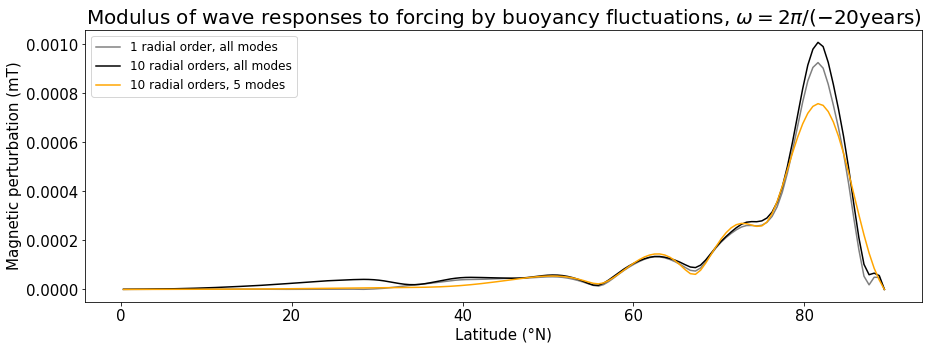

In [11]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
(by_rms_r1*1e3).plot(ax=ax,x='latitude',color='gray',label=r'1 radial order, all modes')
(by_rms_r10*1e3).plot(ax=ax,x='latitude',color='k',label=r'10 radial orders, all modes')
(by_rms_r10_5modes*1e3).plot(ax=ax,x='latitude',color='orange',label=r'10 radial orders, 5 modes')


ax.legend(fontsize=12)
ax.set_ylabel(r'Magnetic perturbation (mT)')
ax.set_xlabel('Latitude (°N)')
ax.set_title(r"Modulus of wave responses to forcing by buoyancy fluctuations, $\omega = 2\pi/(-20\mathrm{ years})$",fontsize=20)



## $b_y$ response

In [10]:
%time by_rms_buoyancy_r1_fd,vy_rms_buoyancy_r1_fd,by_powspec_buoyancy_r1_fd,by_powspec_buoyancy_r1_fd_hl = forced_waves_rms_fast(param,1,buoyNHonly,buoySHonly,limitmodes=300)


Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 52.5 s, sys: 2.94 s, total: 55.4 s
Wall time: 16.2 s


Text(0.5, 0, 'Latitude (°N)')

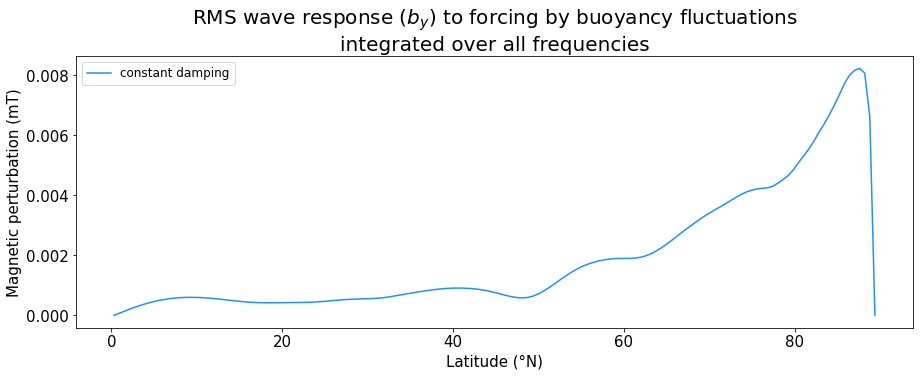

In [26]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
(by_rms_buoyancy_r1_fd*1e3).plot(ax=ax,x='latitude',color='dodgerblue',label=r'constant damping')

ax.set_ylabel(r'Magnetic perturbation (mT)')
ax.set_title("RMS wave response ($b_y$) to forcing by buoyancy fluctuations\nintegrated over all frequencies",fontsize=20)
ax.legend(fontsize=12)
ax.set_xlabel('Latitude (°N)')

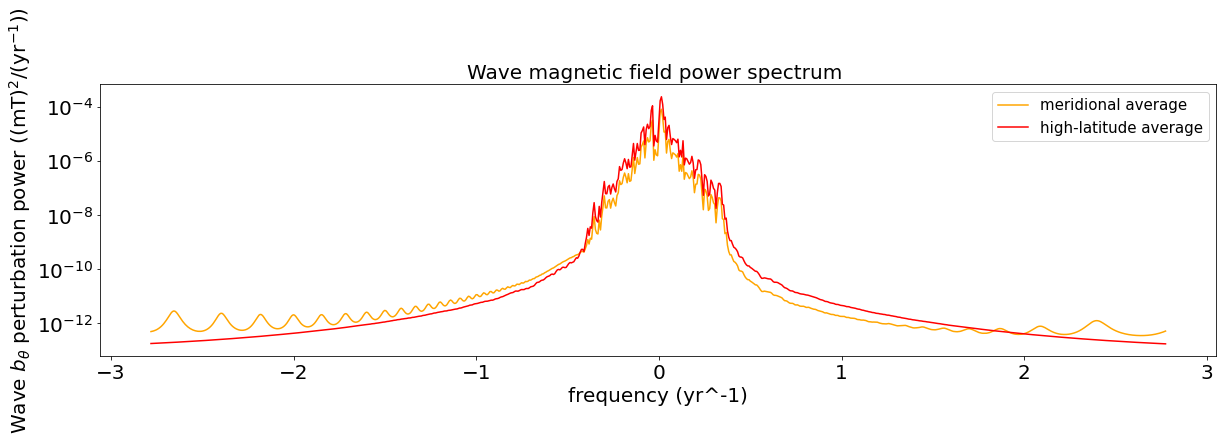

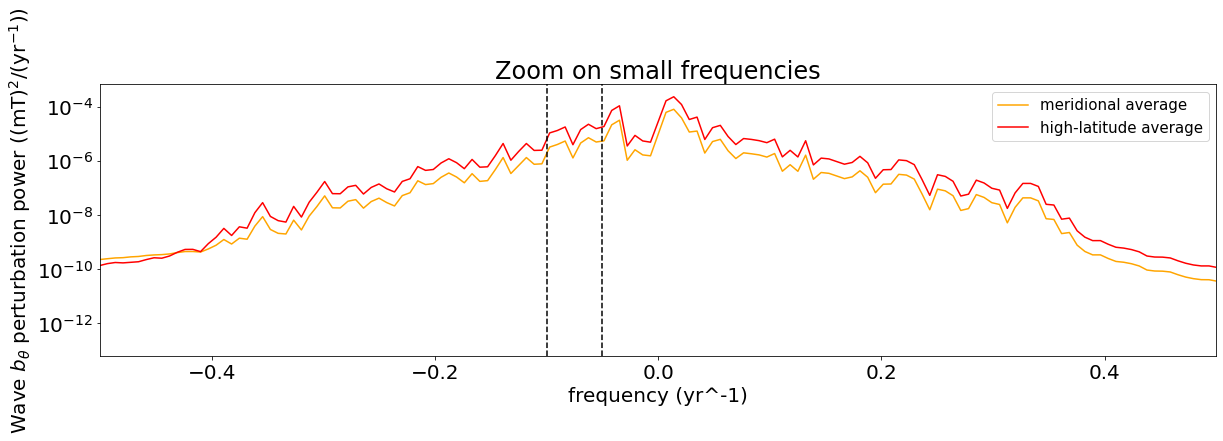

In [47]:
for _ in range(2):
    _,ax=plt.subplots(1,1,figsize=(20,5))
    
    (1e6/sectoyear*by_powspec_buoyancy_r1_fd   ).plot(ax=ax,x='frequency_yr',color='orange',label=r'meridional average')
    (1e6/sectoyear*by_powspec_buoyancy_r1_fd_hl).plot(ax=ax,x='frequency_yr',color='r',label=r'high-latitude average')
  
    ax.legend(fontsize=15)
    ax.set_xlabel('frequency (yr^-1)')
    ax.set_ylabel(r'Wave $b_\theta$ perturbation power ((mT)$^2$/(yr$^{-1}$))')
    ax.set_title(r"Wave magnetic field power spectrum ",fontsize=20)
    ax.set_yscale('log')
ax.set_xlim(-0.5,0.5)
ax.set_title("Zoom on small frequencies")
ax.axvline(-0.1,color='k',linestyle='--')
ax.axvline(-0.05,color='k',linestyle='--')

In [48]:
freqindex_m20 = period_to_freqindex(-20*sectoyear)
deltafreq = (nonzero_frequencies()[1]-nonzero_frequencies()[0])
print("RMS, meridional avg b_theta = %.1e mT"%(1e3*np.sqrt(by_powspec_buoyancy_r1_fd.sel(frequency=1/(-20*sectoyear),method='nearest')*deltafreq)))
print("RMS, highlat avg b_theta = %.1e mT"%(1e3*np.sqrt(by_powspec_buoyancy_r1_fd_hl.sel(frequency=1/(-20*sectoyear),method='nearest')*deltafreq)))



RMS, meridional avg b_theta = 2.0e-04 mT
RMS, highlat avg b_theta = 3.6e-04 mT


In [ ]:
print("RMS, highlat avg b_theta = %.1e mT"%(1e3*np.sqrt(np.max(by_powspec_induction_theta_r1_fd_hl)*deltafreq)))


RMS, highlat avg b_theta = 2.5e-01 mT


The idea here is to relax the assumption that $|\mathbf{v}\cdot\nabla\mathbf{B}| \ll |\mathbf{B}\cdot\nabla\mathbf{v}|$, and write the diffusionless induction equation as:
$$\dot b_r = [\nabla \times (\mathbf{v}\times\mathbf{B})]_r = - \nabla_H \cdot(\mathbf{v}_HB_r)$$
Time variations of $B_r$ are much slower than the wave variations, hence 
$$\ddot b_r  \simeq - \nabla_H \cdot(\dot{\mathbf{v}}_HB_r) = - B_r\nabla_H \cdot\dot{\mathbf{v}}_H - \dot{\mathbf{v}}_H\cdot \nabla_H B_r$$
We evaluate the second term using $\|\nabla_H B_r\| \simeq 6\times 10^{-10}$ T/m (at 70°N, $B_r$ varies from 1 mT to 0 mT over a distance of 45° longitude)

In [42]:
def bref_to_brddot(param,b_ref):
    omega_ref = 2*np.pi/(-20*sectoyear)
    k = np.pi/param.H
    chi = 1 +1j*k**2/omega_ref*param.eta #Size : Nf*jmax*1
    
    v_ref = 1j*omega_ref*chi*b_ref/(k*param.Br) #See scaling formula from induction eqn
    vdot_ref = 1j*omega_ref*v_ref
    
    gradBr_ref = 1e-3/(np.pi/4*6400e3*np.cos(70*np.pi/180))
    
    print("br_ddot = %.4f \mu T/yr^2"%(np.abs(vdot_ref)*gradBr_ref*1e6*sectoyear**2))
    
#Peak value more like 4e-3 mT. 
b_ref = 4e-7 #b_theta in Tesla at high latitudes
bref_to_brddot(param,b_ref)

br_ddot = 0.0020 \mu T/yr^2


In [43]:
bref_to_brddot(param,3.6e-7)
bref_to_brddot(param,4.8e-5)
bref_to_brddot(param,7.2e-6)

br_ddot = 0.0018 \mu T/yr^2
br_ddot = 0.2458 \mu T/yr^2
br_ddot = 0.0369 \mu T/yr^2


# Lorentz source

In [11]:
lorrNHonly = zeroforcing.copy(); lorrNHonly['Fr'] = lorentz_r_y_tilda_NH
lorrSHonly = zeroforcing.copy(); lorrSHonly['Fr'] = lorentz_r_y_tilda_SH
lortNHonly = zeroforcing.copy(); lortNHonly['Ftheta'] = lorentz_theta_y_tilda_NH
lortSHonly = zeroforcing.copy(); lortSHonly['Ftheta'] = lorentz_theta_y_tilda_SH
lorpNHonly = zeroforcing.copy(); lorpNHonly['Fphi'] = lorentz_phi_y_tilda_NH
lorpSHonly = zeroforcing.copy(); lorpSHonly['Fphi'] = lorentz_phi_y_tilda_SH

In [12]:
%time by_rms_lorentz_r_r1_fd    ,vy_rms_lorentz_r_r1_fd    ,by_powspec_lorentz_r_r1_fd    ,by_powspec_lorentz_r_r1_fd_hl     = forced_waves_rms_fast(param,1,lorrNHonly,lorrSHonly,limitmodes=300)
%time by_rms_lorentz_theta_r1_fd,vy_rms_lorentz_theta_r1_fd,by_powspec_lorentz_theta_r1_fd,by_powspec_lorentz_theta_r1_fd_hl = forced_waves_rms_fast(param,1,lortNHonly,lortSHonly,limitmodes=300)
%time by_rms_lorentz_phi_r1_fd  ,vy_rms_lorentz_phi_r1_fd  ,by_powspec_lorentz_phi_r1_fd  ,by_powspec_lorentz_phi_r1_fd_hl   = forced_waves_rms_fast(param,1,lorpNHonly,lorpSHonly,limitmodes=300)


Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 49.5 s, sys: 4.03 s, total: 53.5 s
Wall time: 17.3 s
Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 50.9 s, sys: 2.98 s, total: 53.9 s
Wall time: 15.9 s
Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 55.1 s, sys: 3.23 s, total: 58.3 s
Wall time: 16.7 s


Text(0.5, 0, 'Latitude (°N)')

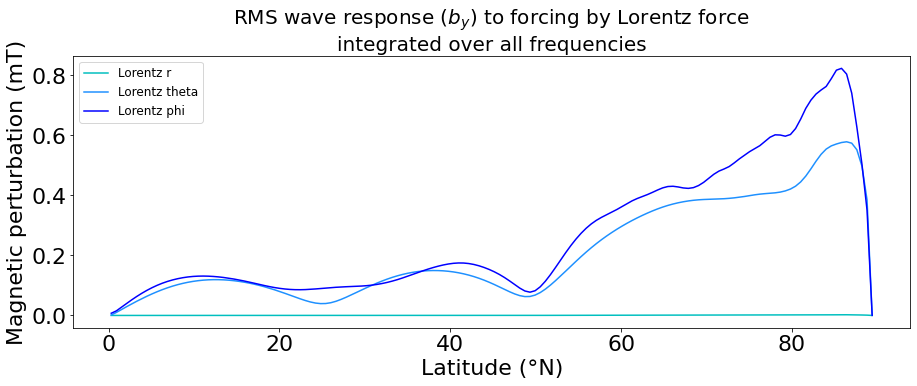

In [45]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
(by_rms_lorentz_r_r1_fd    *1e3).plot(ax=ax,x='latitude',color='c',label=r'Lorentz r')
(by_rms_lorentz_theta_r1_fd*1e3).plot(ax=ax,x='latitude',color='dodgerblue',label=r'Lorentz theta')
(by_rms_lorentz_phi_r1_fd  *1e3).plot(ax=ax,x='latitude',color='blue',label=r'Lorentz phi')
ax.set_ylabel(r'Magnetic perturbation (mT)')
ax.set_title("RMS wave response ($b_y$) to forcing by Lorentz force\nintegrated over all frequencies",fontsize=20)
ax.legend(fontsize=12)
ax.set_xlabel('Latitude (°N)')

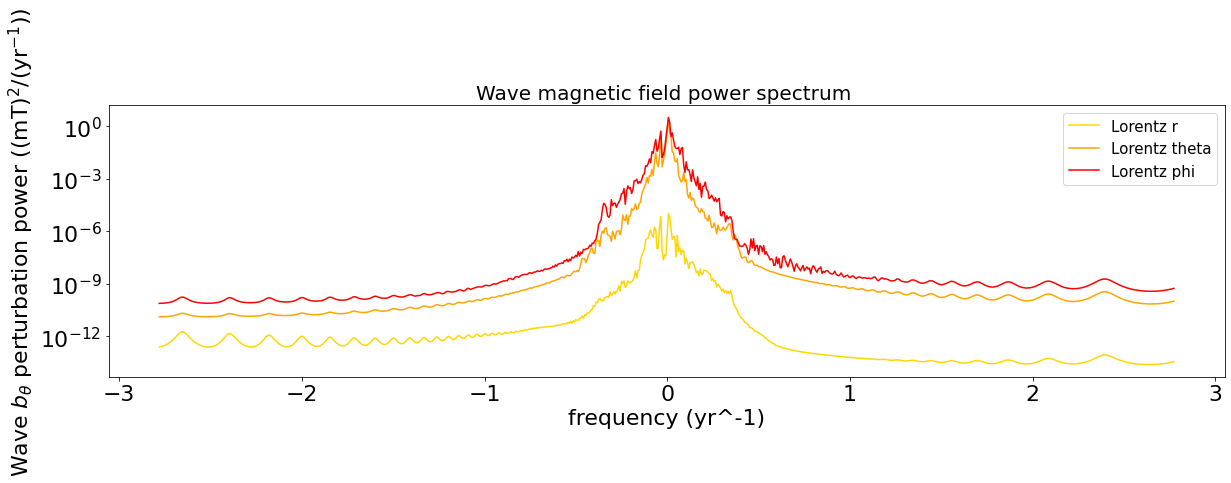

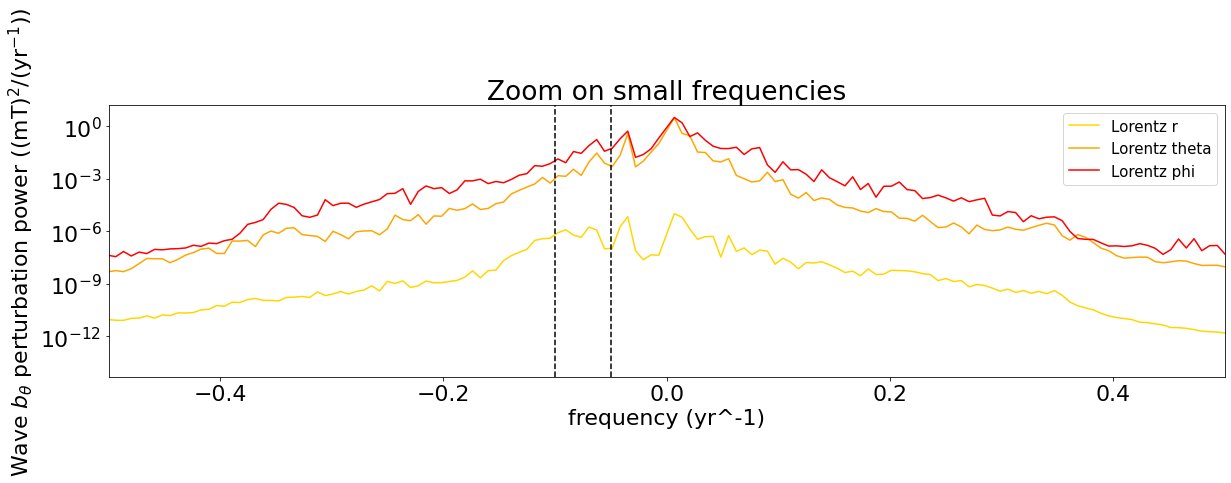

In [46]:
for _ in range(2):
    _,ax=plt.subplots(1,1,figsize=(20,5))
    
    (1e6/sectoyear*by_powspec_lorentz_r_r1_fd    ).plot(ax=ax,x='frequency_yr',color='gold',label=r'Lorentz r')
    (1e6/sectoyear*by_powspec_lorentz_theta_r1_fd).plot(ax=ax,x='frequency_yr',color='orange',label=r'Lorentz theta')
    (1e6/sectoyear*by_powspec_lorentz_phi_r1_fd  ).plot(ax=ax,x='frequency_yr',color='r',label=r'Lorentz phi')
        
    ax.legend(fontsize=15)
    ax.set_xlabel('frequency (yr^-1)')
    ax.set_ylabel(r'Wave $b_\theta$ perturbation power ((mT)$^2$/(yr$^{-1}$))')
    ax.set_title(r"Wave magnetic field power spectrum ",fontsize=20)
    ax.set_yscale('log')
ax.set_xlim(-0.5,0.5)
ax.set_title("Zoom on small frequencies")
ax.axvline(-0.1,color='k',linestyle='--')
ax.axvline(-0.05,color='k',linestyle='--')

In [52]:
## This is stronger than previously because we used a different extrapolation factor (bigger by a factor 6)
lehnert_earth=B_rms/(np.sqrt(param.rho0*param.mu0)*param.Omega*param.L)
(lehnert_earth/lehnert_model)**2

0.0009619774872597095

In [22]:
lehnert_earth_2 = np.sqrt(10*1e-15/(5e-7))
lehnert_model_2 = np.sqrt(2*2e-5)
(lehnert_earth_2/lehnert_model_2)**2

0.0005

In [51]:
freqindex_m20 = period_to_freqindex(-20*sectoyear)
deltafreq = (nonzero_frequencies()[1]-nonzero_frequencies()[0])
print("RMS, meridional avg b_theta = %.1e mT"%(1e3*np.sqrt(by_powspec_lorentz_phi_r1_fd.sel(frequency=1/(-20*sectoyear),method='nearest')*deltafreq)))
print("RMS, highlat avg b_theta = %.1e mT"%(1e3*np.sqrt(by_powspec_lorentz_phi_r1_fd_hl.sel(frequency=1/(-20*sectoyear),method='nearest')*deltafreq)))

RMS, meridional avg b_theta = 2.0e-02 mT
RMS, highlat avg b_theta = 3.7e-02 mT


In [46]:
freqindex_m20 = period_to_freqindex(-20*sectoyear)
deltafreq = (nonzero_frequencies()[1]-nonzero_frequencies()[0])
print("RMS, highlat avg b_theta = %.1e mT"%(1e3*np.sqrt(by_powspec_lorentz_theta_r1_fd_hl.sel(frequency=1/(-10*sectoyear),method='nearest')*deltafreq)))
print("RMS, highlat avg b_theta = %.1e mT"%(1e3*np.sqrt(by_powspec_lorentz_phi_r1_fd_hl.sel(frequency=1/(-10*sectoyear),method='nearest')*deltafreq)))

RMS, highlat avg b_theta = 5.9e-03 mT
RMS, highlat avg b_theta = 1.7e-02 mT


In [52]:
freqindex_m20 = period_to_freqindex(-20*sectoyear)
deltafreq = (nonzero_frequencies()[1]-nonzero_frequencies()[0])
print("RMS, highlat avg b_theta = %.1e mT"%(1e3*np.sqrt(by_powspec_lorentz_theta_r1_fd_hl.sel(frequency=1/(-20*sectoyear),method='nearest')*deltafreq)))
print("RMS, highlat avg b_theta = %.1e mT"%(1e3*np.sqrt(by_powspec_lorentz_phi_r1_fd_hl.sel(frequency=1/(-20*sectoyear),method='nearest')*deltafreq)))

RMS, highlat avg b_theta = 1.1e-02 mT
RMS, highlat avg b_theta = 3.7e-02 mT


In [50]:
freqindex_m20 = period_to_freqindex(-20*sectoyear)
deltafreq = (nonzero_frequencies()[1]-nonzero_frequencies()[0])
print("RMS, highlat avg b_theta = %.1e mT"%(1e3*np.sqrt(by_powspec_lorentz_theta_r1_fd_hl.sel(frequency=1/(-30*sectoyear),method='nearest')*deltafreq)))
print("RMS, highlat avg b_theta = %.1e mT"%(1e3*np.sqrt(by_powspec_lorentz_phi_r1_fd_hl.sel(frequency=1/(-30*sectoyear),method='nearest')*deltafreq)))

RMS, highlat avg b_theta = 9.5e-02 mT
RMS, highlat avg b_theta = 1.1e-01 mT


In [48]:
bref_to_brddot(param,2.3e-5)

br_ddot = 0.1178 \mu T/yr^2


In [54]:
bref_to_brddot(param,4.8e-5)

br_ddot = 0.2458 \mu T/yr^2


In [53]:
bref_to_brddot(param,20.5e-5)

br_ddot = 1.0498 \mu T/yr^2


# Induction source

In [13]:
BtNHonly = zeroforcing.copy(); BtNHonly['FItheta'] = B_theta_y_tilda_NH
BtSHonly = zeroforcing.copy(); BtSHonly['FItheta'] = B_theta_y_tilda_SH
BpNHonly = zeroforcing.copy(); BpNHonly['FIphi'] = B_phi_y_tilda_NH
BpSHonly = zeroforcing.copy(); BpSHonly['FIphi'] = B_phi_y_tilda_SH

In [14]:
%time by_rms_induction_theta_r1_fd,vy_rms_induction_theta_r1_fd,by_powspec_induction_theta_r1_fd,by_powspec_induction_theta_r1_fd_hl = forced_waves_rms_fast(param,1,BtNHonly,BtSHonly,limitmodes=300)
%time by_rms_induction_phi_r1_fd  ,vy_rms_induction_phi_r1_fd  ,by_powspec_induction_phi_r1_fd  ,by_powspec_induction_phi_r1_fd_hl   = forced_waves_rms_fast(param,1,BpNHonly,BpSHonly,limitmodes=300)


Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 54.8 s, sys: 3.01 s, total: 57.8 s
Wall time: 15.7 s
Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 51.6 s, sys: 4 s, total: 55.6 s
Wall time: 15.4 s


Text(0.5, 0, 'Latitude (°N)')

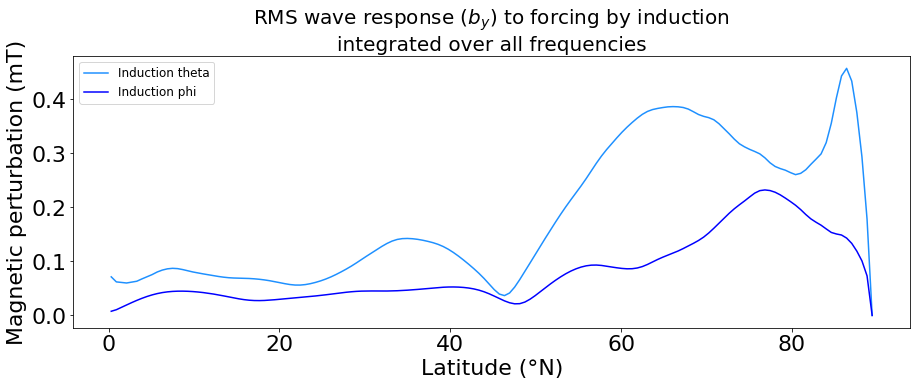

In [56]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
(by_rms_induction_theta_r1_fd*1e3).plot(ax=ax,x='latitude',color='dodgerblue',label=r'Induction theta')
(by_rms_induction_phi_r1_fd  *1e3).plot(ax=ax,x='latitude',color='blue',label=r'Induction phi')
ax.set_ylabel(r'Magnetic perturbation (mT)')
ax.set_title("RMS wave response ($b_y$) to forcing by induction\nintegrated over all frequencies",fontsize=20)
ax.legend(fontsize=12)
ax.set_xlabel('Latitude (°N)')

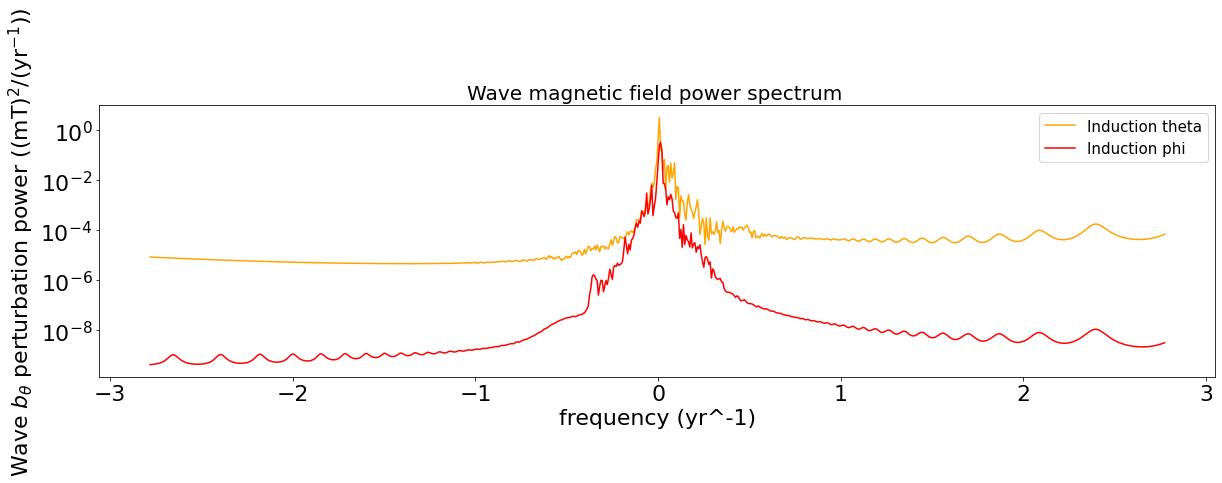

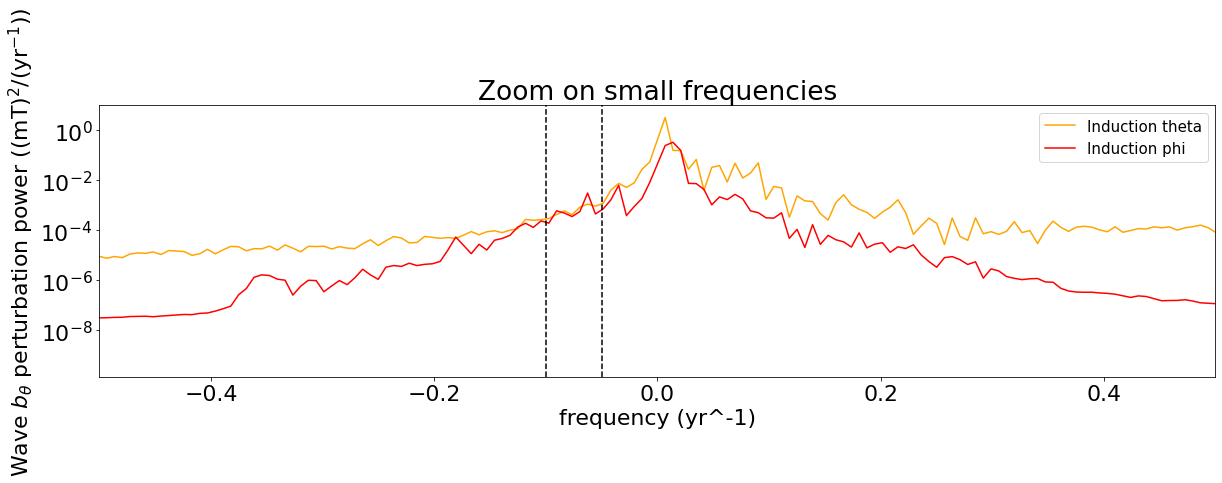

In [57]:
for _ in range(2):
    _,ax=plt.subplots(1,1,figsize=(20,5))
    
    (1e6/sectoyear*by_powspec_induction_theta_r1_fd).plot(ax=ax,x='frequency_yr',color='orange',label=r'Induction theta')
    (1e6/sectoyear*by_powspec_induction_phi_r1_fd  ).plot(ax=ax,x='frequency_yr',color='r',label=r'Induction phi')
        
    ax.legend(fontsize=15)
    ax.set_xlabel('frequency (yr^-1)')
    ax.set_ylabel(r'Wave $b_\theta$ perturbation power ((mT)$^2$/(yr$^{-1}$))')
    ax.set_title(r"Wave magnetic field power spectrum ",fontsize=20)
    ax.set_yscale('log')
ax.set_xlim(-0.5,0.5)
ax.set_title("Zoom on small frequencies")
ax.axvline(-0.1,color='k',linestyle='--')
ax.axvline(-0.05,color='k',linestyle='--')

In [54]:
freqindex_m20 = period_to_freqindex(-20*sectoyear)
deltafreq = (nonzero_frequencies()[1]-nonzero_frequencies()[0])
print("RMS, meridional avg b_theta = %.1e mT"%(1e3*np.sqrt(by_powspec_induction_phi_r1_fd.sel(frequency=1/(-20*sectoyear),method='nearest')*deltafreq)))
print("RMS, highlat avg b_theta = %.1e mT"%(1e3*np.sqrt(by_powspec_induction_phi_r1_fd_hl.sel(frequency=1/(-20*sectoyear),method='nearest')*deltafreq)))

RMS, meridional avg b_theta = 2.2e-03 mT
RMS, highlat avg b_theta = 4.0e-03 mT


In [55]:
b_ref = 4e-6 #b_theta in Tesla at high latitudes
bref_to_brddot(param,b_ref)

br_ddot = 0.020 \mu T/yr^2


# Paper figures

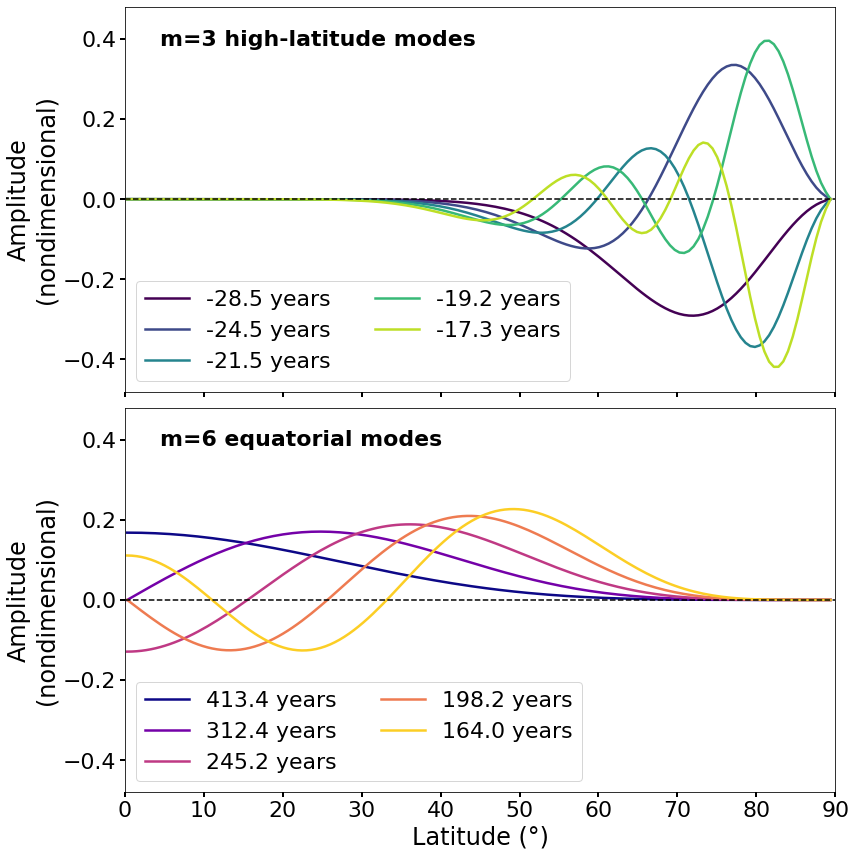

In [33]:
# Plotting the first few high-lat and equatorial eigenmodes
def plot_eigenmodes(ax,n1,n2,westward_traveling=True,m=3,colors=1,loc=2):
    ngrid=150

    k = np.pi/param.H
    period0=(-20)*sectoyear
    omega = 2*np.pi / period0
    
    C0 = 2*param.Omega*k**2*param.R**2/(param.N**2)
    C = C0*omega
    _,M,chi = CMchi(param,period0,1)
    
    # Compute matrix and eigendecomposition, with dirichlet BC
    y=set_y(ngrid)
    A = set_A(ngrid,param.m,M,option=1)
    wi,xi=spl.eig(A)
    if not westward_traveling: # Add Neumann BC solutions as well
        A = set_A(ngrid,param.m,M,option=2)
        wi_n,xi_n=spl.eig(A)
        wi=np.concatenate([wi,wi_n])
        xi=np.concatenate([xi,xi_n],axis=1)
    #Merge all eigenvalues and eigenvectors; and sort them by increasing period
    if westward_traveling:
        order=np.argsort(np.real(1/wi))
    else:
        order=np.argsort(-np.real(1/wi))
        xi*=np.sign(xi[len(y)-10])
    xi=xi[:len(y),order]/(1-y[:,None]**2)
    wi=wi[order]
    
    lns='-'
    lw=2.5
    if colors==1:
        clrs=plt.cm.viridis(np.linspace(0,0.9,n2-n1))
    elif colors==2:
        clrs=plt.cm.plasma(np.linspace(0,0.9,n2-n1))
    
    for i in range(n1,n2):
        eigenmode_period = np.real(2*np.pi*C0/(wi[i]*sectoyear))
        ax.plot(np.arcsin(y)*180.0/np.pi,np.real(xi[:,i]),label="%.1f years"%eigenmode_period,linestyle=lns,linewidth=lw,color=clrs[i-n1])

    ax.set_xlim(0,90)
    ax.legend(loc=loc,ncol=2)#,fontsize=20,borderpad=0.3,labelspacing=0.4,borderaxespad=0.3)
    ax.set_ylim(-0.48,0.48)
    ax.set_ylabel("Amplitude\n(nondimensional)",fontsize=24)
    ax.axhline(0.,linestyle='--',color='k')
    ax.tick_params(width=2,length=5)
    


matplotlib.rcParams.update({'font.size':22})
fig,(ax,ax2)=plt.subplots(2,1,figsize=(12,12))
plot_eigenmodes(ax ,0,5,westward_traveling=True ,m=3,colors=1,loc=3)
plot_eigenmodes(ax2,0,5,westward_traveling=False,m=6,colors=2,loc=3)
ax2.set_xlabel("Latitude (°)",fontsize=24)
ax.set_xticks(range(0,100,10))
ax.set_xticklabels([""]*10)
xt=0.05;yt=0.9
ax.text( xt,yt, 'm=3 high-latitude modes',fontweight='bold', transform=ax.transAxes)
ax2.text(xt,yt, 'm=6 equatorial modes'   ,fontweight='bold', transform=ax2.transAxes)
fig.tight_layout(pad=0.5)
#fig.savefig('/Users/quentin.nicolas/Downloads/modes.eps', format='eps',bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

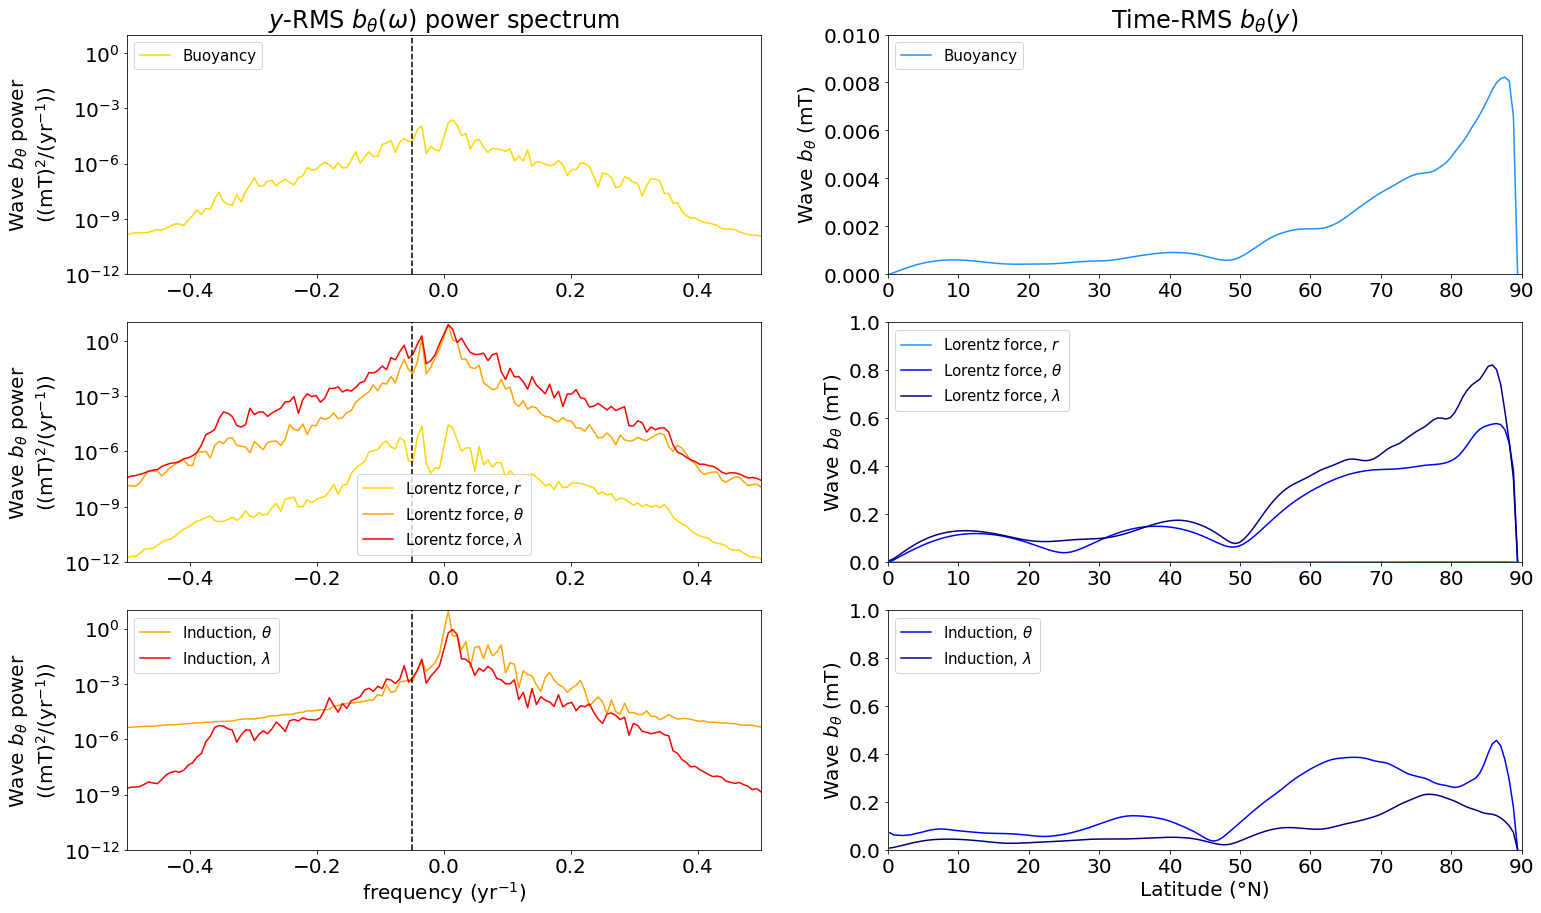

In [232]:
# Excited waves
matplotlib.rcParams.update({'font.size':20})
fig,axs=plt.subplots(3,2,figsize=(25,15))

# Buoyancy
(1e6/sectoyear*by_powspec_buoyancy_r1_fd_hl    ).plot(ax=axs[0,0],x='frequency_yr',color='gold'  ,label=r"Buoyancy"     )

(by_rms_buoyancy_r1_fd    *1e3).plot(ax=axs[0,1],x='latitude',color='dodgerblue',label=r"Buoyancy"     )


# Lorentz
(1e6/sectoyear*by_powspec_lorentz_r_r1_fd_hl    ).plot(ax=axs[1,0],x='frequency_yr',color='gold'  ,label=r"Lorentz force, $r$"     )
(1e6/sectoyear*by_powspec_lorentz_theta_r1_fd_hl).plot(ax=axs[1,0],x='frequency_yr',color='orange',label=r"Lorentz force, $\theta$")
(1e6/sectoyear*by_powspec_lorentz_phi_r1_fd_hl  ).plot(ax=axs[1,0],x='frequency_yr',color='r'     ,label=r"Lorentz force, $\lambda$"  )
    
(by_rms_lorentz_r_r1_fd    *1e3).plot(ax=axs[1,1],x='latitude',color='dodgerblue',label=r"Lorentz force, $r$"     )
(by_rms_lorentz_theta_r1_fd*1e3).plot(ax=axs[1,1],x='latitude',color='blue'      ,label=r"Lorentz force, $\theta$")
(by_rms_lorentz_phi_r1_fd  *1e3).plot(ax=axs[1,1],x='latitude',color='navy'      ,label=r"Lorentz force, $\lambda$"  )
    
# Induction
(1e6/sectoyear*by_powspec_induction_theta_r1_fd_hl).plot(ax=axs[2,0],x='frequency_yr',color='orange',label=r"Induction, $\theta$")
(1e6/sectoyear*by_powspec_induction_phi_r1_fd_hl  ).plot(ax=axs[2,0],x='frequency_yr',color='r'     ,label=r"Induction, $\lambda$"  )
        
(by_rms_induction_theta_r1_fd*1e3).plot(ax=axs[2,1],x='latitude',color='blue',label=r"Induction, $\theta$")
(by_rms_induction_phi_r1_fd  *1e3).plot(ax=axs[2,1],x='latitude',color='navy',label=r"Induction, $\lambda$"  )


axs[2,0].set_xlabel(r'frequency (yr$^{-1}$)')
axs[2,1].set_xlabel('Latitude (°N)')
    

for ax in axs[:,0]:    
    ax.set_yscale('log')
    ax.set_ylabel(r'Wave $b_\theta$ power' '\n' '((mT)$^2$/(yr$^{-1}$))')
    ax.set_xlim(-0.5,0.5)
    ax.axvline(-0.05,color='k',linestyle='--')
    ax.set_ylim(1e-12,10)
    ax.legend(loc=2,fontsize=15)
for ax in axs[:,1]:   
    ax.set_ylabel(r'Wave $b_\theta$ (mT)')
    ax.legend(loc=2,fontsize=15)
for ax in axs[:-1].reshape(-1):
    ax.set_xlabel('')
    ax.set_title('')

axs[0,1].set_ylim(0.,1e-2); axs[0,1].set_xlim(0,90)
axs[1,1].set_ylim(0.,1)   ; axs[1,1].set_xlim(0,90)   
axs[2,1].set_ylim(0.,1)   ; axs[2,1].set_xlim(0,90)  

axs[1,0].legend(loc=8,fontsize=15)

axs[0,1].set_title(r"Time-RMS $b_\theta(y)$",fontsize=24)
axs[0,0].set_title(r"$y$-RMS $b_\theta(\omega)$ power spectrum",fontsize=24)

fig.savefig('/Users/quentin.nicolas/Downloads/computedWaves.eps', format='eps',bbox_inches='tight')

# Correction of source terms

## Lorentz

In [22]:
B_r_y   = B_rms/lehnert_model *np.sqrt(E_sim/Pm_sim)*(B_y_nd.magnetic_field_r_real+1j*B_y_nd.magnetic_field_r_imag)
cutoff_radius = np.where(B_y_nd.radius>1.475)[0][0]

In [41]:
print("Lorentz theta RMS: %.2e m/s2"%np.sqrt(np.abs(lorentz_theta_y[:,cutoff_radius:]**2).mean()))
print("Lorentz phi   RMS: %.2e m/s2"%np.sqrt(np.abs(lorentz_phi_y[:,cutoff_radius:]  **2).mean()))
print("Lorentz r     RMS: %.2e m/s2"%np.sqrt(np.abs(lorentz_r_y[:,cutoff_radius:]    **2).mean()))

Lorentz theta RMS: 7.20e-10 m/s2
Lorentz phi   RMS: 7.26e-10 m/s2
Lorentz r     RMS: 1.17e-09 m/s2


In [75]:
print("B theta RMS: %.2e T"%np.sqrt(np.abs(B_theta_y[:,cutoff_radius:]**2).mean()))
print("B phi   RMS: %.2e T"%np.sqrt(np.abs(B_phi_y[:,cutoff_radius:]  **2).mean()))
print("B r     RMS: %.2e T"%np.sqrt(np.abs(B_r_y[:,cutoff_radius:]    **2).mean()))

B theta RMS: 1.74e-04 T
B phi   RMS: 2.91e-04 T
B r     RMS: 1.05e-04 T


In [43]:
lorentz_theta_corr = 1/(param.rho0*param.mu0)*param.Br * B_theta_y.differentiate('radius') / param.L
lorentz_phi_corr   = 1/(param.rho0*param.mu0)*param.Br * B_phi_y.differentiate('radius')   / param.L
lorentz_r_corr     = 1/(param.rho0*param.mu0)*param.Br * B_r_y.differentiate('radius')     / param.L

In [44]:
print("Lorentz theta correction RMS: %.2e m/s2"%np.sqrt(np.abs(lorentz_theta_corr[:,cutoff_radius:]**2).mean()))
print("Lorentz phi   correction RMS: %.2e m/s2"%np.sqrt(np.abs(lorentz_phi_corr[:,cutoff_radius:]  **2).mean()))
print("Lorentz r     correction RMS: %.2e m/s2"%np.sqrt(np.abs(lorentz_r_corr[:,cutoff_radius:]    **2).mean()))

Lorentz theta correction RMS: 2.70e-10 m/s2
Lorentz phi   correction RMS: 3.49e-10 m/s2
Lorentz r     correction RMS: 2.38e-11 m/s2


In [46]:
lorentz_theta_cd = lorentz_theta_y - lorentz_theta_corr
lorentz_phi_cd   = lorentz_phi_y   - lorentz_phi_corr
lorentz_r_cd     = lorentz_r_y     - lorentz_r_corr

In [47]:
print("Lorentz theta corrected RMS: %.2e m/s2"%np.sqrt(np.abs(lorentz_theta_cd[:,cutoff_radius:]**2).mean()))
print("Lorentz phi   corrected RMS: %.2e m/s2"%np.sqrt(np.abs(lorentz_phi_cd[:,cutoff_radius:]  **2).mean()))
print("Lorentz r     corrected RMS: %.2e m/s2"%np.sqrt(np.abs(lorentz_r_cd[:,cutoff_radius:]    **2).mean()))

Lorentz theta corrected RMS: 7.21e-10 m/s2
Lorentz phi   corrected RMS: 7.31e-10 m/s2
Lorentz r     corrected RMS: 1.17e-09 m/s2


In [50]:
lorentz_theta_y_tilda = transform_forcing(lorentz_theta_y,'cos')
lorentz_phi_y_tilda   = transform_forcing(lorentz_phi_y,'cos')
lorentz_r_y_tilda     = transform_forcing(lorentz_r_y,'cos')


In [55]:
lorentz_theta_cd_tilda = transform_forcing(lorentz_theta_cd,'cos')
lorentz_phi_cd_tilda   = transform_forcing(lorentz_phi_cd,'cos')
lorentz_r_cd_tilda     = transform_forcing(lorentz_r_cd,'cos')


In [61]:
def assign_freq(ds):
    frequency_yr = ds.frequency*sectoyear
    frequency_yr.attrs['unit']='yr^-1'
    return ds.assign_coords(frequency_yr=frequency_yr).sortby('frequency')

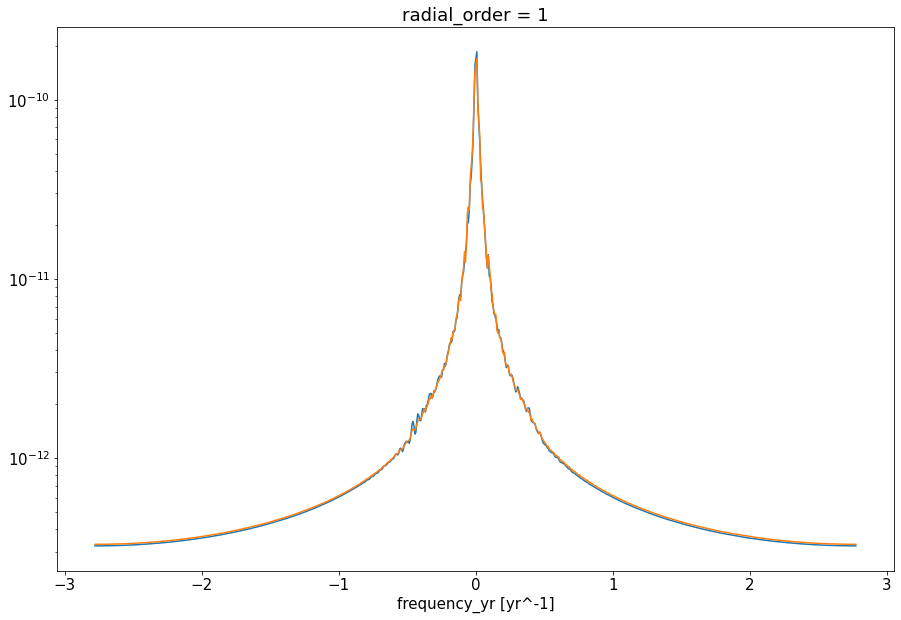

In [65]:
plt.figure(figsize=(15,10))
assign_freq(np.sqrt(np.abs(lorentz_theta_y_tilda[:,0]**2).mean('y')) ).plot(x='frequency_yr',label='original')
assign_freq(np.sqrt(np.abs(lorentz_theta_cd_tilda[:,0]**2).mean('y'))).plot(x='frequency_yr',label='corrected')
plt.yscale('log')

## Induction

In [79]:
velocity_y_nd = xr.open_dataset("data/data808/velocity_y_300_cos.nc")
velocity_theta_y_nd = velocity_y_nd.velocity_theta_real+1j*velocity_y_nd.velocity_theta_imag
velocity_phi_y_nd   = velocity_y_nd.velocity_phi_real+1j*velocity_y_nd.velocity_phi_imag

velocity_theta_y_nd *= E_sim
velocity_phi_y_nd   *= E_sim

Omega_adjusted = 4.405286343612335e-08
velocity_theta_y = Omega_adjusted*param.L*velocity_theta_y_nd
velocity_phi_y   = Omega_adjusted*param.L*velocity_phi_y_nd

In [104]:
induction_theta_corr = param.Br * velocity_theta_y.differentiate('radius') / param.L
induction_phi_corr   = param.Br * velocity_phi_y  .differentiate('radius') / param.L


In [91]:
induction_theta_y = B_theta_y.assign_coords({'time_dim':B_theta_y.time/E_sim/Omega_adjusted}).differentiate('time_dim')
induction_phi_y   = B_phi_y.assign_coords({'time_dim':B_phi_y.time/E_sim/Omega_adjusted}).differentiate('time_dim')

In [92]:
print("Induction theta RMS: %.2e T/s"%np.sqrt(np.abs(induction_theta_y[:,cutoff_radius:]**2).mean()))
print("Induction phi   RMS: %.2e T/s"%np.sqrt(np.abs(induction_phi_y[:,cutoff_radius:]  **2).mean()))


Induction theta RMS: 2.46e-13 T/s
Induction phi   RMS: 4.07e-13 T/s


In [105]:
print("Induction theta correction RMS: %.2e T/s"%np.sqrt(np.abs(induction_theta_corr[:,cutoff_radius:]**2).mean()))
print("Induction phi   correction RMS: %.2e T/s"%np.sqrt(np.abs(induction_phi_corr[:,cutoff_radius:]  **2).mean()))


Induction theta correction RMS: 2.25e-12 T/s
Induction phi   correction RMS: 2.41e-12 T/s


In [106]:
induction_theta_y_tilda      = transform_forcing(induction_theta_y,'cos')
induction_theta_corr_tilda   = transform_forcing(induction_theta_corr,'cos')

induction_phi_y_tilda      = transform_forcing(induction_phi_y,'cos')
induction_phi_corr_tilda   = transform_forcing(induction_phi_corr,'cos')


In [100]:
B_theta_y_tilda = transform_forcing(B_theta_y,'cos')
omegas = 2*np.pi*nonzero_frequencies()

In [61]:
def assign_freq(ds):
    frequency_yr = ds.frequency*sectoyear
    frequency_yr.attrs['unit']='yr^-1'
    return ds.assign_coords(frequency_yr=frequency_yr).sortby('frequency')

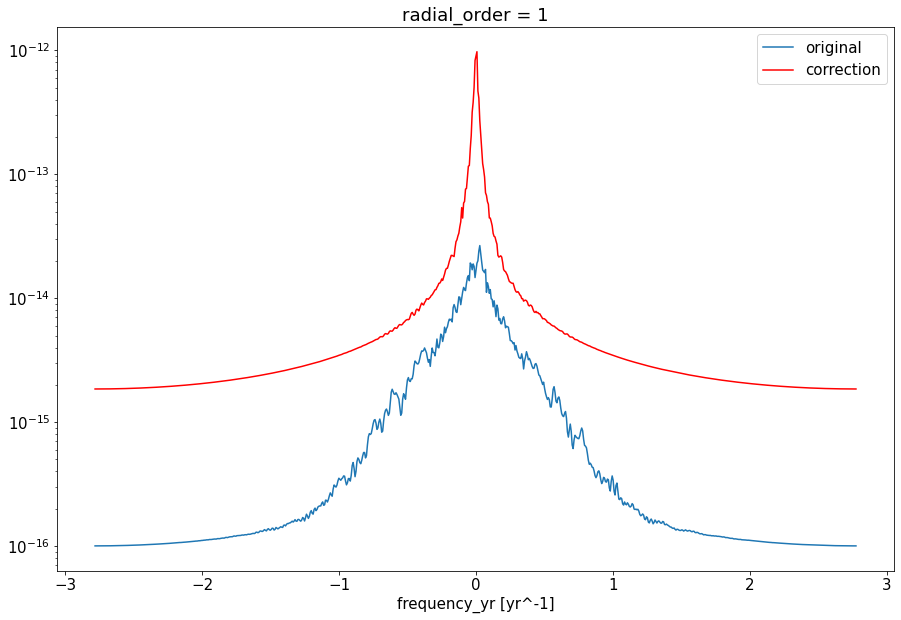

In [115]:
plt.figure(figsize=(15,10))
assign_freq(np.sqrt(np.abs(induction_theta_y_tilda[:,0]**2).mean('y')) ).plot(x='frequency_yr',label='original')
assign_freq(np.sqrt(np.abs(induction_theta_corr_tilda[:,0]**2).mean('y'))).plot(x='frequency_yr',color='r',label='correction')
plt.yscale('log')
plt.legend()

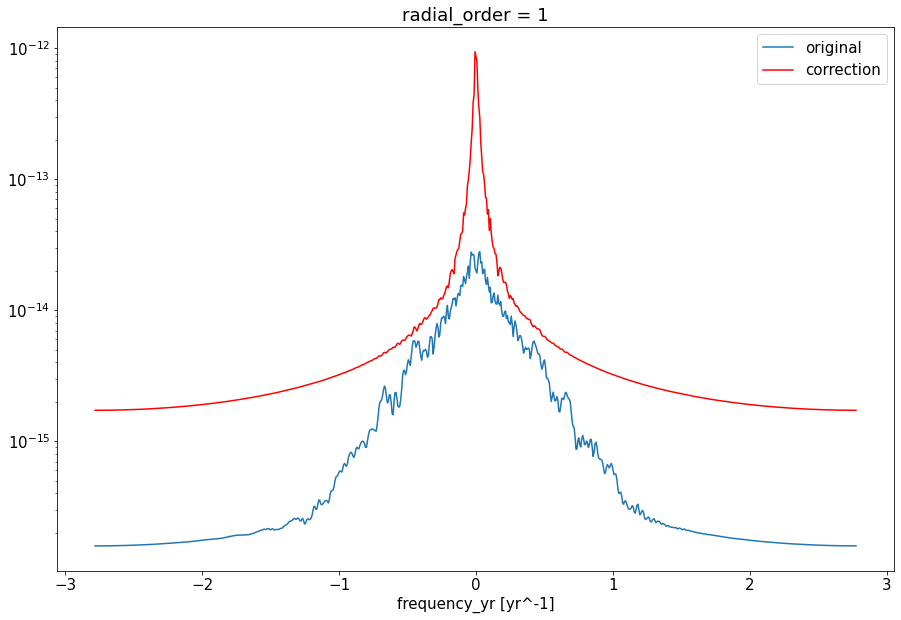

In [118]:
plt.figure(figsize=(15,10))
assign_freq(np.sqrt(np.abs(induction_phi_y_tilda[:,0]**2).mean('y')) ).plot(x='frequency_yr',label='original')
assign_freq(np.sqrt(np.abs(induction_phi_corr_tilda[:,0]**2).mean('y'))).plot(x='frequency_yr',color='r',label='correction')
plt.yscale('log')
plt.legend()

# Uncertainty estimates

In [251]:
buoyancy_y_layer = buoyancy_y[:,np.where(buoyancy_y.radius>1.475)[0][0]:]

b_t = np.sqrt(np.abs(buoyancy_y_layer)**2).mean(["radius_ID","y"])
2*b_t.std()/np.sqrt(7)/b_t.mean()*100

<xarray.DataArray ()>
array(12.42249469)

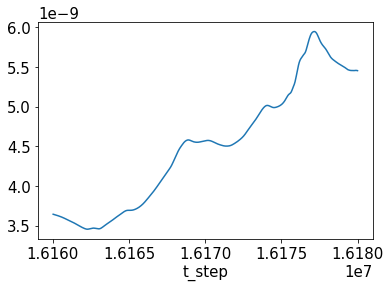

In [247]:
b_t.plot()

In [249]:
lorentz_theta_y_layer = lorentz_theta_y[:,np.where(lorentz_theta_y.radius>1.475)[0][0]:]

lt_t = np.sqrt(np.abs(lorentz_theta_y_layer)**2).mean(["radius_ID","y"])
2*lt_t.std()/np.sqrt(7)/lt_t.mean()*100

<xarray.DataArray ()>
array(6.66403427)
Coordinates:
    order    int64 -3

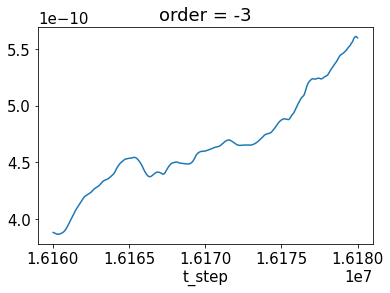

In [250]:
lt_t.plot()

# Quality factors

In [180]:
def periods_QFs(param,period0=-20):
    """Computes C,M and damping term chi"""
    k = np.pi/param.H
    omega = 2*np.pi / (period0*sectoyear)
    chi = 1 +1j*param.eta*k**2/omega
    
    M = param.Br**2*k**4*param.R**2/(param.rho0*param.mu0*chi*param.N**2)
    
    ngrid=150
    y=set_y(ngrid)
    A = set_A(ngrid,param.m,M,option=1)
    Ci,_=spl.eig(A)
    order=np.argsort(np.real(1/Ci))
    Ci=Ci[order]
    
    qfs = np.real(Ci)/2/np.imag(Ci)
    
    C0 = 2*param.Omega*k**2*param.R**2/(param.N**2)
    omegas = Ci/C0
    periods = np.real(2*np.pi*C0/(Ci*sectoyear))
    return periods,qfs
    
param = Param()
param.m=3                   # nondimensional
param.L = 2260e3            # m
param.R = param.L/0.65      # m
param.rho0=1e4              # kg m^-3
param.mu0=4e-7*np.pi        # T m A^-1


In [181]:
param.H = 140e3             # m
param.Omega = 2*np.pi/86400 # s^-1
param.N = 0.5 * param.Omega # s^-1
param.Br = 0.5e-3           # T
param.eta=0.8               # m^2 s^-1
p_earth,qf_earth = periods_QFs(param)


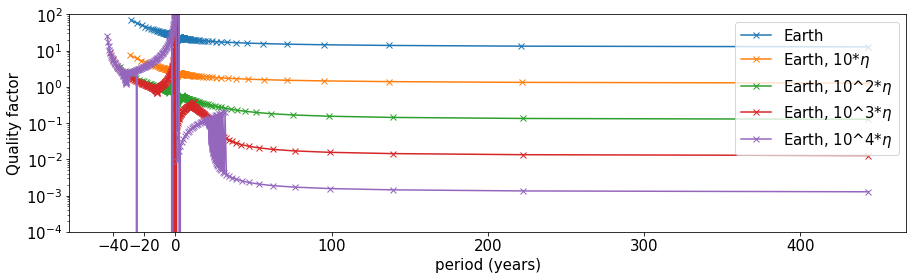

In [182]:
plt.figure(figsize=(15,4))
plt.plot(p_earth,qf_earth,'-x',label="Earth")
param.eta=0.8*1e1;plt.plot(*periods_QFs(param),'-x',label=r"Earth, 10*$\eta$")
param.eta=0.8*1e2;plt.plot(*periods_QFs(param),'-x',label=r"Earth, 10^2*$\eta$")
param.eta=0.8*1e3;plt.plot(*periods_QFs(param),'-x',label=r"Earth, 10^3*$\eta$")
param.eta=0.8*1e4;plt.plot(*periods_QFs(param),'-x',label=r"Earth, 10^4*$\eta$")
plt.yscale('log');plt.ylim(1e-4,1e2)
plt.xlabel("period (years)")
plt.ylabel("Quality factor")
plt.xticks([-40,-20]+list(range(0,401,100)))
plt.legend();None

In [316]:
param_calypso = Param()
param_calypso.m=3                   # nondimensional
param_calypso.L = 2260e3            # m
param_calypso.R = param.L/0.65      # m
param_calypso.rho0=1e4              # kg m^-3
param_calypso.mu0=4e-7*np.pi        # T m A^-1

param_calypso.H = 290e3             # m
param_calypso.Omega = 2*np.pi/86400 # s^-1
param_calypso.N = 0.14 * param.Omega # s^-1
param_calypso.Br = 7e-3*np.sqrt(param_calypso.rho0*param_calypso.mu0)*param_calypso.Omega*param_calypso.L           # T

param_calypso.eta=2*1e-5*  param_calypso.Omega*param_calypso.L**2             # m^2 s^-1

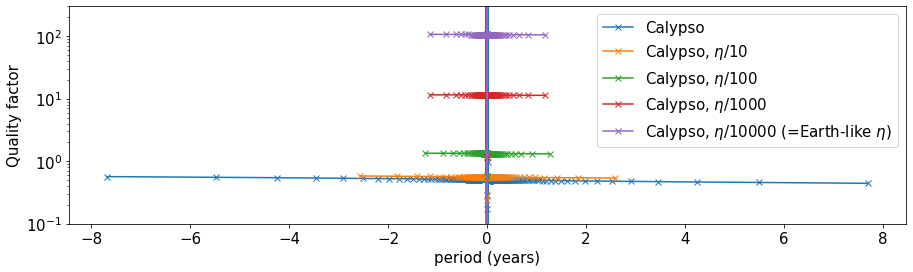

In [193]:
plt.figure(figsize=(15,4))
plt.plot(*periods_QFs(param_calypso),'-x',label="Calypso")
param_calypso.eta/=10;plt.plot(*periods_QFs(param_calypso),'-x',label=r"Calypso, $\eta$/10")
param_calypso.eta/=10;plt.plot(*periods_QFs(param_calypso),'-x',label=r"Calypso, $\eta$/100")
param_calypso.eta/=10;plt.plot(*periods_QFs(param_calypso),'-x',label=r"Calypso, $\eta$/1000")
param_calypso.eta=0.8;plt.plot(*periods_QFs(param_calypso),'-x',label=r"Calypso, $\eta$/10000 (=Earth-like $\eta$)")
plt.yscale('log');plt.ylim(1e-1,3e2)
plt.xlabel("period (years)")
plt.ylabel("Quality factor")
plt.legend();None

In [168]:
param_calypso = Param()
param_calypso.m=3                   # nondimensional
param_calypso.L = 2260e3            # m
param_calypso.R = param.L/0.65      # m
param_calypso.rho0=1e4              # kg m^-3
param_calypso.mu0=4e-7*np.pi        # T m A^-1

param_calypso.H = 290e3             # m
param_calypso.Omega = 4.4e-8 # s^-1
param_calypso.N = 0.14 * param.Omega # s^-1
param_calypso.Br = 7e-3*np.sqrt(param_calypso.rho0*param_calypso.mu0)*param_calypso.Omega*param_calypso.L           # T

param_calypso.eta=2*1e-5*  param_calypso.Omega*param_calypso.L**2             # m^2 s^-1
print("eta:",param_calypso.eta, "m^2/s")

eta: 4.494688 m^2/s


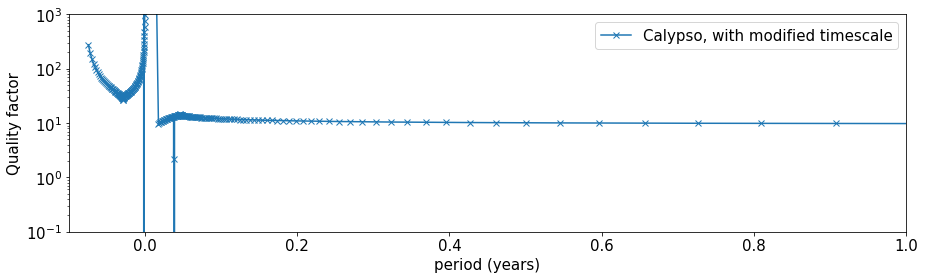

In [167]:
plt.figure(figsize=(15,4))
plt.plot(*periods_QFs(param_calypso),'-x',label="Calypso, with modified timescale")
#param_calypso.eta/=10;plt.plot(*periods_QFs(param_calypso),'-x',label="Calypso, damping/10")
plt.yscale('log');plt.ylim(1e-1,1e3)
plt.xlim(-0.1,1)
plt.xlabel("period (years)")
plt.ylabel("Quality factor")
plt.legend();None

# Tests on the regularity of the wave equation

In [253]:
CMchi(param,-20*sectoyear,1)

(array(-6.66658784), array(0.04604949+0.00186343j), array(1.-0.04046577j))

In [281]:
_,M,_ = CMchi(param,-20*sectoyear,1)
ngrid=450
A = set_A(ngrid,1,M)
y = set_y(ngrid)
wi,_,xi = compute_eigendecomp(A)
xi = xi[:ngrid]

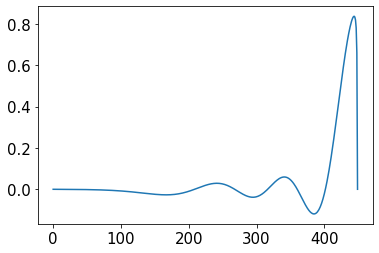

In [284]:
plt.plot(np.real(xi[:,5])/(1-y**2),'-')

(-100.0, 100.0)

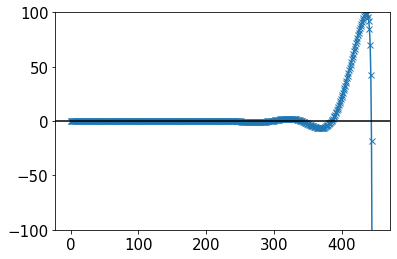

In [300]:
plt.plot(np.gradient(np.real(xi[:,5])/(1-y**2),y),'-x')
plt.axhline(0.,color='k')
plt.ylim(-100,100)

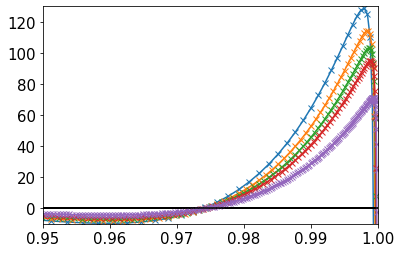

In [307]:
def get_dxidy(ngrid):
    A = set_A(ngrid,1,M)
    y = set_y(ngrid)
    _,_,xi = compute_eigendecomp(A)
    xi = xi[:ngrid]
    return y,np.gradient(np.real(xi[:,5])/(1-y**2),y)
#data=[]
for i,ngrid in enumerate((200,300,400,500,1000)):
    #data.append(get_dxidy(ngrid))
    plt.plot(*data[i],'-x')
    plt.axhline(0.,color='k')
    plt.ylim(-10,130)
    plt.xlim(0.95,1)

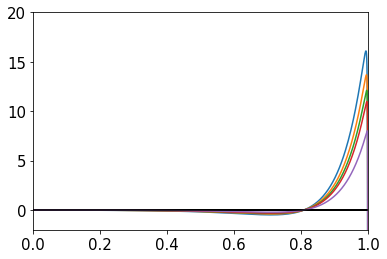

In [315]:
def get_dxidy(ngrid):
    A = set_A(ngrid,1,M)
    y = set_y(ngrid)
    _,_,xi = compute_eigendecomp(A)
    xi = xi[:ngrid]
    return y,np.gradient(np.real(xi[:,1])/(1-y**2),y)
#data1=[]
for i,ngrid in enumerate((200,300,400,500,1000)):
    #data1.append(get_dxidy(ngrid))
    plt.plot(*data1[i],'-')
    plt.axhline(0.,color='k')
    plt.ylim(-2,20)
    plt.xlim(0.,1)

# Synthetic tests

In [213]:
synthetic = lorentz_r_y_tilda_NH.copy()
freqs_bct,_=xr.broadcast(synthetic.frequency,synthetic)
synthetic = (3*np.abs(1e20*freqs_bct)**(-1)) #*(synthetic.y**6*(1-synthetic.y)**0.5*10+0.5)
testforcing=zeroforcing.copy()
testforcing['Ftheta']=synthetic

In [214]:
%time testy2,_,testpow2,testpowhl2 = forced_waves_rms_fast(param,1,testforcing,zeroforcing,limitmodes=300)


Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 33.4 s, sys: 7.26 s, total: 40.7 s
Wall time: 19.7 s


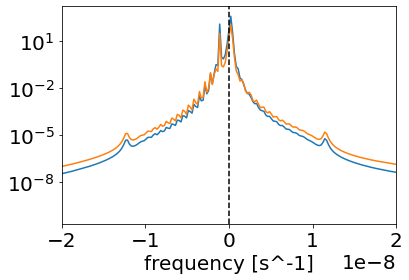

In [216]:
testpow.plot()
testpow2.plot()
#plt.plot(testpow2.frequency,testpow2[::-1])
plt.yscale('log')
plt.xlim(-2e-8,2e-8)
plt.axvline(0.,color='k',linestyle='--')

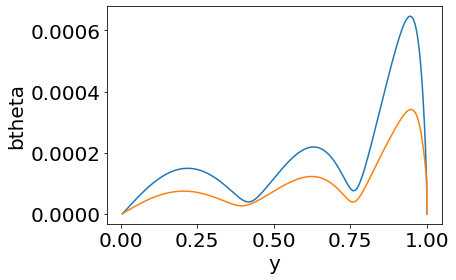

In [219]:
testy.plot()
testy2.plot()

In [224]:
from numpy.linalg import solve

/Users/quentin.nicolas/miniconda3/envs/macwaves/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


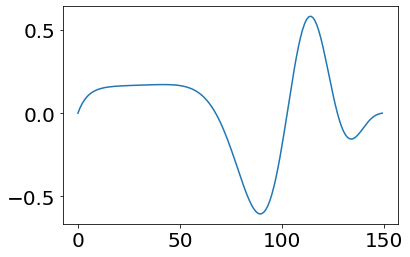

In [231]:
ngrid = 150
period=-20*sectoyear ## fixed damping
_,M,chi = CMchi(param,period,1)
A = set_A(ngrid,param.m,M)
#wi,zi,xi = compute_eigendecomp(A)
#
#np.sum(np.dot(zi[:,n0:n0+limitmodes].conj().T,rhs)/(wi[n0:n0+limitmodes]-C) * xi[:,n0:n0+limitmodes],axis=1)[:ngrid]/(1-y**2)

plt.plot(solve(A+6*np.eye(300),np.ones(300))[:150])

# Eastward traveling guys

In [10]:
%time by,bye,byw = forced_waves_rms_fast(param,1,buoyNHonly,buoySHonly,limitmodes=300)


Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 51 s, sys: 4.76 s, total: 55.8 s
Wall time: 18.3 s


Text(0.5, 0, 'Latitude (°N)')

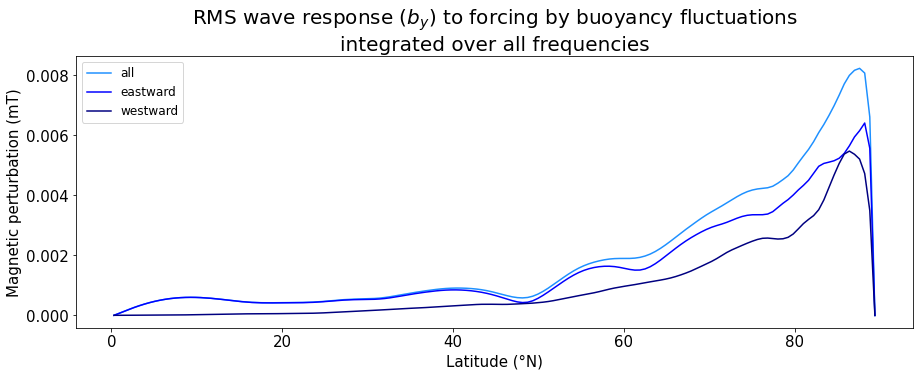

In [11]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
(by*1e3).plot(ax=ax,x='latitude',color='dodgerblue',label=r'all')
(bye*1e3).plot(ax=ax,x='latitude',color='b',label=r'eastward')
(byw*1e3).plot(ax=ax,x='latitude',color='navy',label=r'westward')

#((bye+byw)*1e3/1.414).plot(ax=ax,x='latitude',color='r',label=r'constant damping')

ax.set_ylabel(r'Magnetic perturbation (mT)')
ax.set_title("RMS wave response ($b_y$) to forcing by buoyancy fluctuations\nintegrated over all frequencies",fontsize=20)
ax.legend(fontsize=12)
ax.set_xlabel('Latitude (°N)')

In [17]:
param2 = Param()
param2.m=6                   # nondimensional
param2.eta=0.8               # m^2 s^-1
param2.L = 2260e3            # m
param2.R = param.L/0.65      # m
param2.H = 140e3             # m
param2.Omega = 2*np.pi/86400 # s^-1
param2.N = 0.5 * param.Omega # s^-1
param2.Br = 0.5e-3           # T
param2.rho0=1e4              # kg m^-3
param2.mu0=4e-7*np.pi        # T m A^-1
%time by6,bye6,byw6 = forced_waves_rms_fast(param2,1,buoyNHonly**0,buoySHonly**0,limitmodes=300)


Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 55.5 s, sys: 3.83 s, total: 59.3 s
Wall time: 17.8 s


Text(0.5, 0, 'Latitude (°N)')

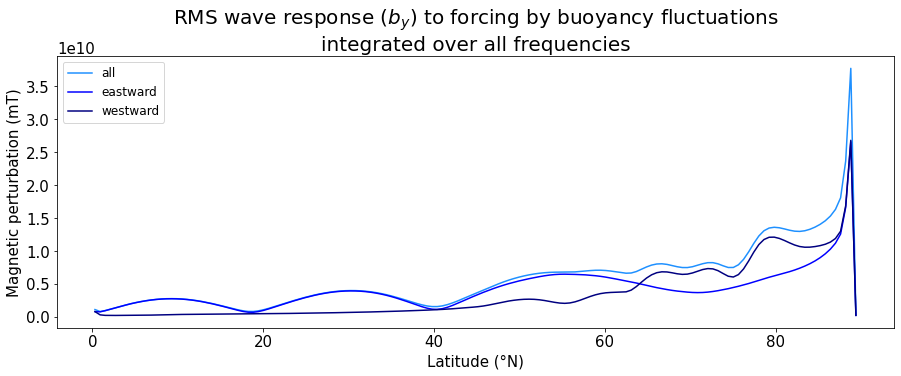

In [18]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
(by6*1e3).plot(ax=ax,x='latitude',color='dodgerblue',label=r'all')
(bye6*1e3).plot(ax=ax,x='latitude',color='b',label=r'eastward')
(byw6*1e3).plot(ax=ax,x='latitude',color='navy',label=r'westward')

#((bye+byw)*1e3/1.414).plot(ax=ax,x='latitude',color='r',label=r'constant damping')

ax.set_ylabel(r'Magnetic perturbation (mT)')
ax.set_title("RMS wave response ($b_y$) to forcing by buoyancy fluctuations\nintegrated over all frequencies",fontsize=20)
ax.legend(fontsize=12)
ax.set_xlabel('Latitude (°N)')

# Further tests

In [58]:
param2 = Param()
param2.m=3                   # nondimensional
param2.eta=0.8               # m^2 s^-1
param2.L = 2260e3            # m
param2.R = param.L/0.65      # m
param2.H = 140e3             # m
param2.Omega = 2*np.pi/86400 # s^-1
param2.N = 1 * param.Omega # s^-1
param2.Br = 0.5e-3           # T
param2.rho0=1e4              # kg m^-3
param2.mu0=4e-7*np.pi        # T m A^-1

In [61]:
%time by_rms_buoyancy_r1_fd2,_,by_powspec_buoyancy_r1_fd2,_ = forced_waves_rms_fast(param2,1,buoyNHonly,buoySHonly,limitmodes=300)


Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 47.4 s, sys: 3.9 s, total: 51.3 s
Wall time: 19.2 s


Text(0.5, 0, 'Latitude (°N)')

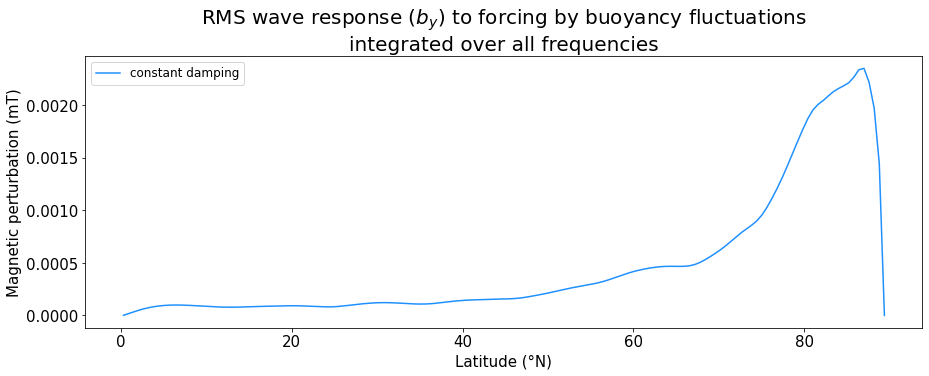

In [60]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
(by_rms_buoyancy_r1_fd*1e3).plot(ax=ax,x='latitude',color='dodgerblue',label=r'constant damping')

ax.set_ylabel(r'Magnetic perturbation (mT)')
ax.set_title("RMS wave response ($b_y$) to forcing by buoyancy fluctuations\nintegrated over all frequencies",fontsize=20)
ax.legend(fontsize=12)
ax.set_xlabel('Latitude (°N)')

In [64]:
param3 = Param()
param3.m=3                   # nondimensional
param3.eta=0.8               # m^2 s^-1
param3.L = 2260e3            # m
param3.R = param.L/0.65      # m
param3.H = 300e3             # m
param3.Omega = 2*np.pi/86400 # s^-1
param3.N = 0.5 * param.Omega # s^-1
param3.Br = 0.5e-3           # T
param3.rho0=1e4              # kg m^-3
param3.mu0=4e-7*np.pi        # T m A^-1

In [65]:
%time by_rms_buoyancy_r1_fd3,_,by_powspec_buoyancy_r1_fd3,_ = forced_waves_rms_fast(param3,1,buoyNHonly,buoySHonly,limitmodes=300)


Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 53.7 s, sys: 3.69 s, total: 57.4 s
Wall time: 17.6 s


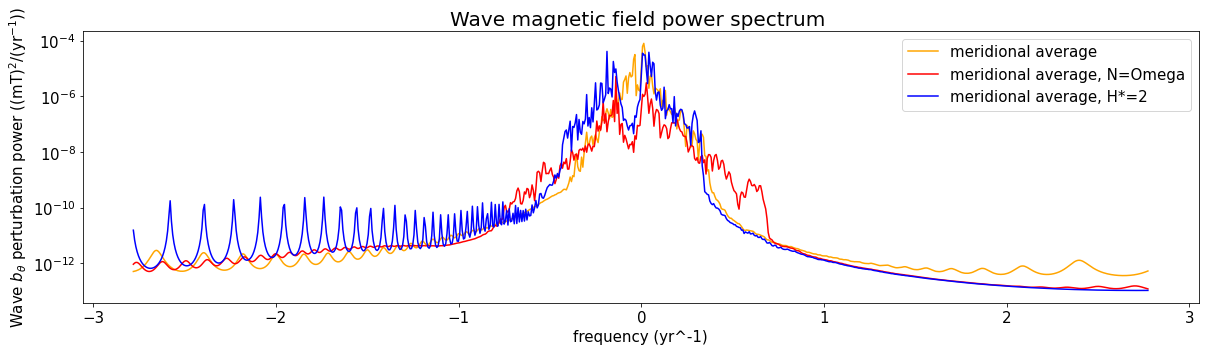

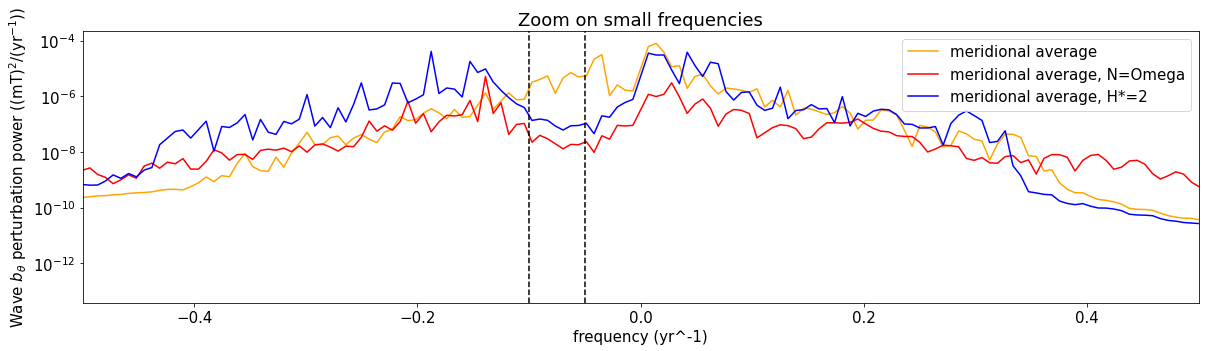

In [66]:
for _ in range(2):
    _,ax=plt.subplots(1,1,figsize=(20,5))
    
    (1e6/sectoyear*by_powspec_buoyancy_r1_fd   ).plot(ax=ax,x='frequency_yr',color='orange',label=r'meridional average')
    (1e6/sectoyear*by_powspec_buoyancy_r1_fd2).plot(ax=ax,x='frequency_yr',color='r',label=r'meridional average, N=Omega')
    (1e6/sectoyear*by_powspec_buoyancy_r1_fd3).plot(ax=ax,x='frequency_yr',color='b',label=r'meridional average, H*=2')
    
    ax.legend(fontsize=15)
    ax.set_xlabel('frequency (yr^-1)')
    ax.set_ylabel(r'Wave $b_\theta$ perturbation power ((mT)$^2$/(yr$^{-1}$))')
    ax.set_title(r"Wave magnetic field power spectrum ",fontsize=20)
    ax.set_yscale('log')
ax.set_xlim(-0.5,0.5)
ax.set_title("Zoom on small frequencies")
ax.axvline(-0.1,color='k',linestyle='--')
ax.axvline(-0.05,color='k',linestyle='--')